# Market-driven Cooling Efficiency Incentive Optimization

This script evaluates an alternative method of defining minimum part-load ("Equipment SEER/IEER") and full-load ("Equipment EER") efficiency levels.  The efficiency levels determine if a given air conditioning "DX Unit" is qualified for a prescriptive rebate in electrical energy efficiency programs.<BR>    
    
The script uses data from the "Large Unitary" equipment category of the AHRI Certification Directory to represent the DX Unit market.  The analysis estimates how changes in minimum qualifying efficiency levels impact the total quantity of certified equipment that exceed the minimum qualifications.  The results from the analysis will be used as guidance in forecasting participation in the MN HVAC-R prescriptive cooling program if the "Flexible Minimum Qualifying" concept is implemented <BR>
    
Matt Chmielewski<BR>
https://github.com/emskiphoto<BR>
July 27, 2021

## Optimization Opportunity
Under this example efficiency program, the net economical benefit of electrical energy savings to the utility is a two-dimensional question.  First, electrical demand (kW) savings benefits are determined by  full-load equipment efficiency.  Second, electrical consumption (kWh) savings are determined by part-load efficiency.  Finally, participating equipment must meet mininimum efficiency levels set for each capacity range.   

Cooling equipment has seen significant improvements in part-load efficiency over recent years, whereas full-load efficiencies have improved little.   This has created a scenario where equipment with excellent part-load performance does not qualify for any incentives because it fails to meet full-load minimum efficiences by a small margin.

The current opportunity is to evaluate a 'flexible' minimum qualifying values that accept variable part-load and full-load efficiencies instead of fixed values by size range.   The benefit is expected to be greater program participation due to more qualified equipment and subsequently greater energy savings claims.  The limit of optimization is defined by the net benefit to the utility - the cost of the more generous minimum qualifying levels must not be low enough to avoid paying more for the efficiency benefits than their expected value to the utility.

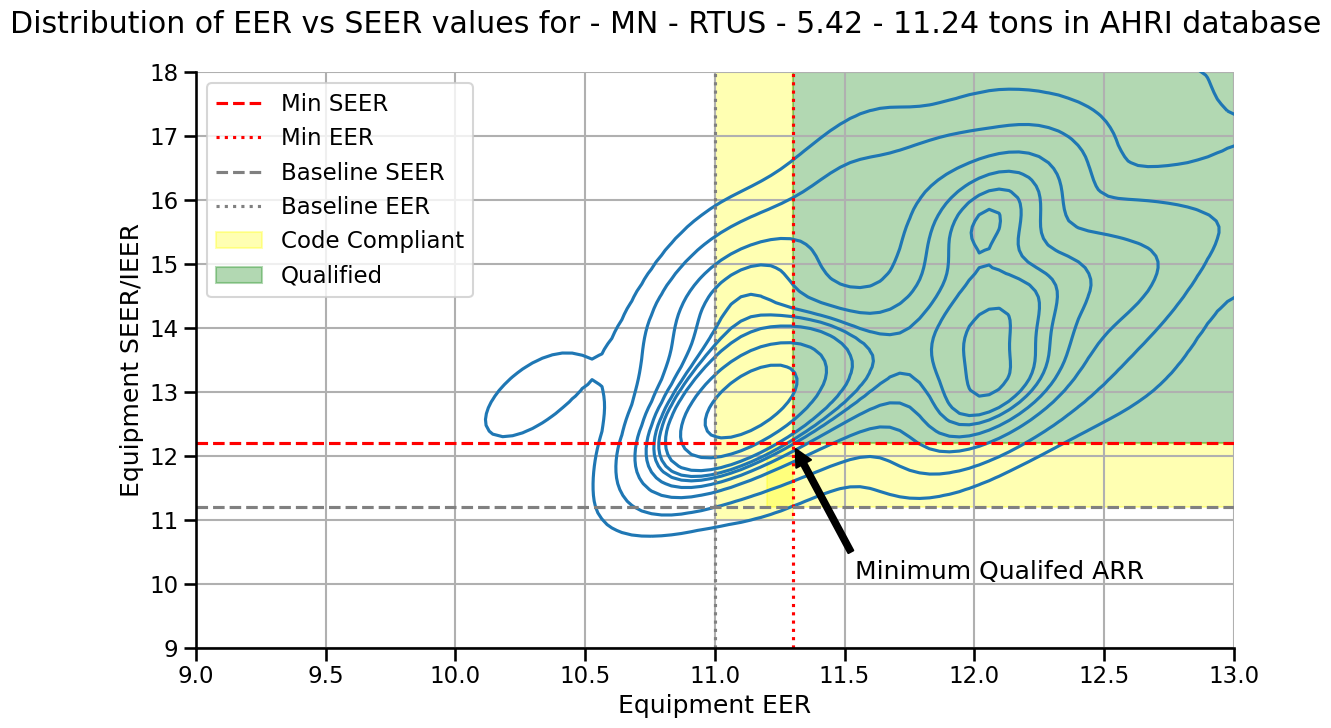

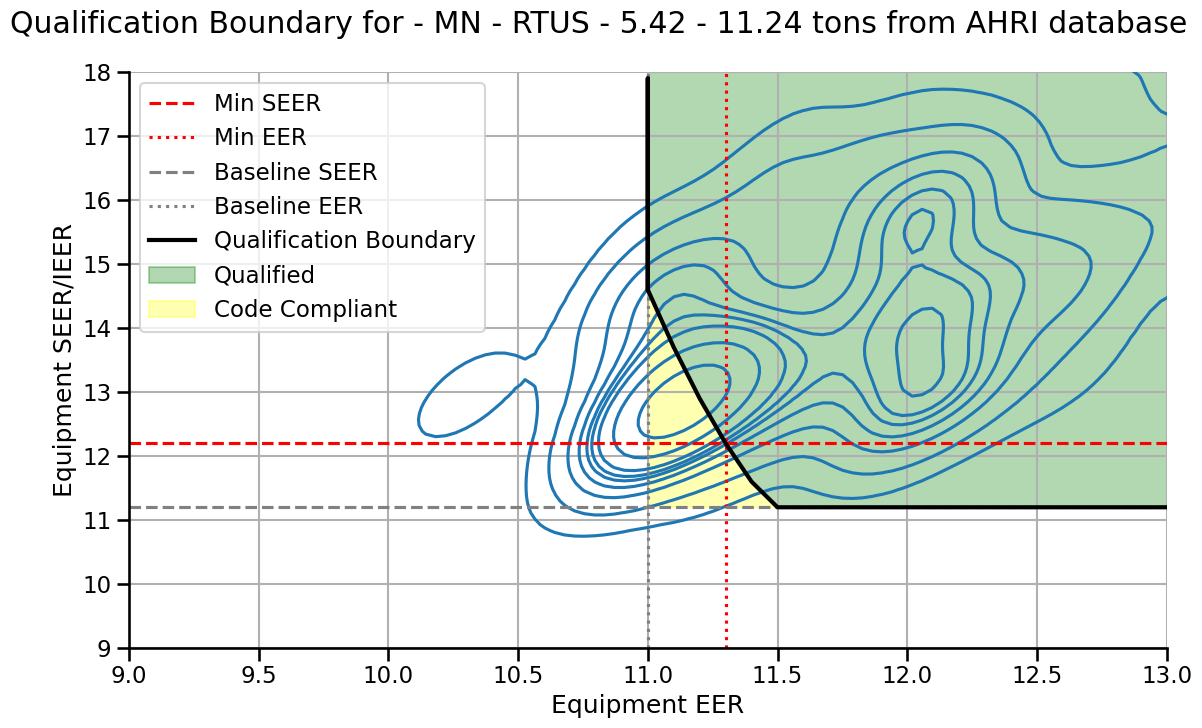

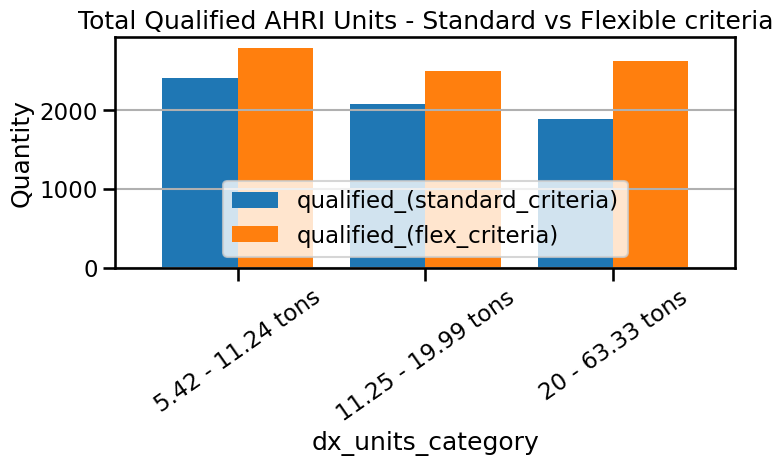

## Process Overview
1. Load and Prepare data
2. What is the significance of DX Units for the energy efficiency program?
3. What are DX Units?
4. What is the opportunity?
5. What levers & buttons can be used?
6. Cost vs Proposed Solution - balance benefits and costs, participation, etc.
7. What is the potential gain?
8. Implementation - Technical Assumptions & Salesforce
9. Lessons Learned

### Load and Prepare data

#### Data Sources:<BR>
__AHRI "Large Unitary"__ - https://www.ahridirectory.org/NewSearch?programId=3&searchTypeId=3&productTypeId=3401. This is considered to be a proxy for the Energy Efficiency Program market and is a best estimate of actual market offering.  This assumption has not been validated in any way.  This study should be further developed to include:
    1. Local cooling market surveys
    2. Exclusion of brands known to not distribute product in the local market<BR>

__DX Units Opportunity History__ - Salesforce <BR>
    
__DX Units Calculation Parameters__ - Salesforce Calculation Parameters<BR>


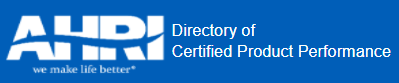

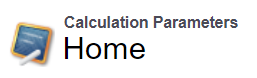

#### Load dependencies & configurations for analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import xcel_utils as xu
%config Completer.use_jedi = False 
sns.set_context('notebook')
plt.rcParams['font.size']= 12

#### Load pre-processed AHRI 'Large Unitary' database

In [4]:
file_AHRI = 'data/AHRI Unitary Large complete.csv'
df = pd.read_csv(file_AHRI, index_col=0)

In [5]:
display(df.shape)
df.head()

(14046, 10)

AHRI Certified Reference Number Model Status Manufacturer Model Number  \
0                          3243059       Active        rheem    RAWL-150D   
1                          3243060       Active        rheem    RAWL-150Y   
2                          3243064       Active        rheem    RAWL-240C   
3                          3243065       Active        rheem    RAWL-240D   
4                          3243066       Active        rheem    RAWL-240Y   

  Indoor Unit Model Number AHRI Type  unit cooling BTUH  Equipment EER  \
0                RHGL-180Z  RCU-A-CB           146000.0          11.10   
1                RHGL-180Y  RCU-A-CB           146000.0          10.18   
2                RHGL-240Z  RCU-A-CB           224000.0           8.99   
3                RHGL-240Z  RCU-A-CB           214000.0           8.99   
4                RHGL-240Y  RCU-A-CB           240000.0          10.00   

   Equipment SEER/IEER  Full Load Indoor Coil Air Quantity (scfm)  
0                 14.6                                     5000.0  
1                 12.0                                     5000.0  
2                 11.6                                     6900.0  
3                 11.6                                     6900.0  
4                 11.6                                     6900.0

C:\Users\237525\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Figure size 800x800 with 0 Axes>

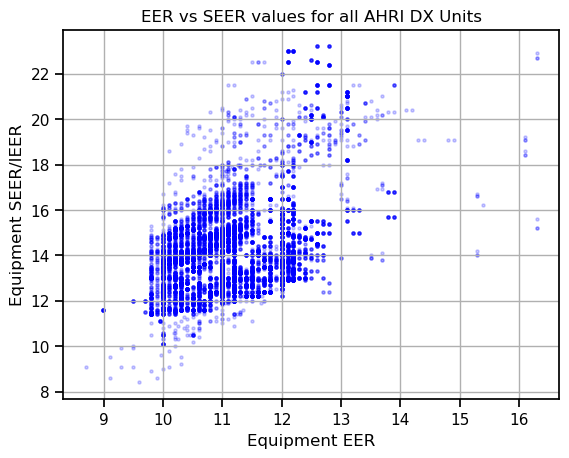

In [6]:
# df.info()
# top_10_mfrs = [x[:15] for x in df.Manufacturer.value_counts().index[:10]]
top_10_mfrs = df.Manufacturer.value_counts().index[:10]
plt.figure(figsize=(8,8))
df.plot(kind='scatter', x='Equipment EER', y='Equipment SEER/IEER', alpha=0.2, marker='.', color='blue')
plt.title('EER vs SEER values for all AHRI DX Units')
plt.grid(axis='both')
plt.show()

As of 4/16/2021 the AHRI Large Unitary Database has 17,863 entries but the file used for analysis has 14,046 entries.   The analysis file was first created in 2019.  Ultimately, changes in total qualified equipment counts will be reported in terms of percentages and not absolute counts.   However, it must be acknowledged that not having the most recent 18+ months of data may underestimate the quantity of newer, and presumably higher efficiency equipment.
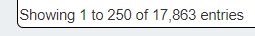

#### Consider only equipment with "active" status
This data set is already 100% Active equipment (as of 2019)

In [7]:
df['Model Status'].value_counts()

Active    14046
Name: Model Status, dtype: int64

In [8]:
df = df.loc[df['Model Status'] == 'Active']

#### Convert equipment capacity from BTUH to Tons
12,000 BTUH = 1 Ton

In [9]:
df['Unit Size (Tons)'] = df['unit cooling BTUH'].apply(lambda x: x/12000)

In [10]:
df[['Unit Size (Tons)', 'unit cooling BTUH']].sample(3)

Unit Size (Tons)  unit cooling BTUH
133          6.000000            72000.0
40          25.666667           308000.0
37          31.666667           380000.0

### Load Minimum Qualifying Cooling Efficiency levels by size range
These are the Energy Efficiency levels that determine qualification for the program.  These values are constant within a given size range.  

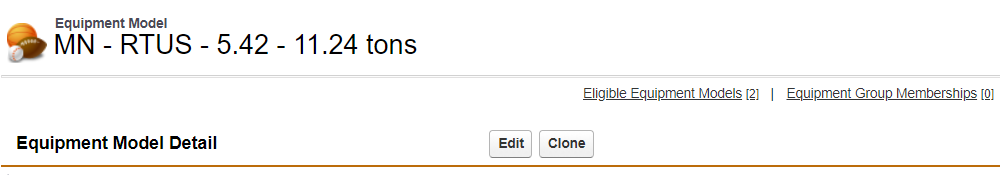
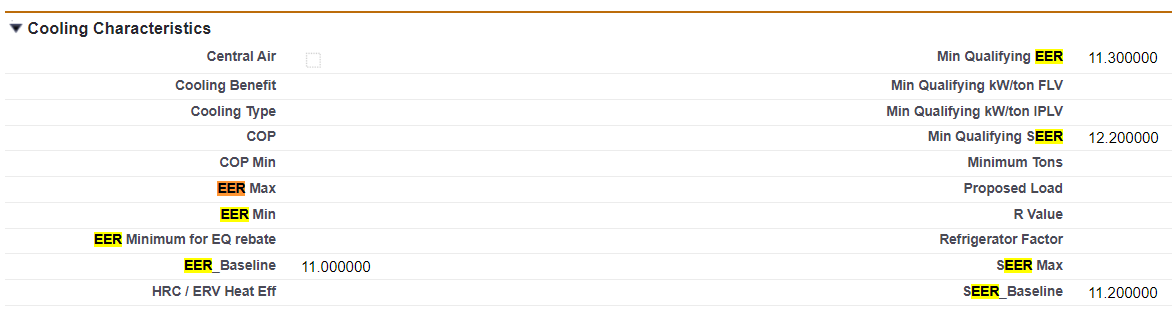

In [13]:
file_equipment = 'data\Cooling Minimum Efficiencies by Size.xlsx'

In [16]:
df_equipment = pd.read_excel(file_equipment, sheet_name='one_table').dropna(axis=1)
labels = list(df_equipment[['eo3__Equipment_Type__c']].values[:,0])

In [15]:
df_equipment[['eo3__Equipment_Type__c','Size_Min__c','Size_Max__c','Min_SEER__c','Min_EER__c']]

eo3__Equipment_Type__c  Size_Min__c  Size_Max__c  Min_SEER__c  \
0             MN - RTUS < 5.42 tons         0.00         5.42         13.7   
1     MN - RTUS - 5.42 - 11.24 tons         5.42        11.25         12.2   
2    MN - RTUS - 11.25 - 19.99 tons        11.25        20.00         12.1   
3       MN - RTUS - 20 - 63.33 tons        20.00        63.34         12.0   
4  MN - RTUS - 63.34 tons and above        63.34       300.00         12.0   

   Min_EER__c  
0       11.05  
1       11.30  
2       11.10  
3       10.90  
4       10.90

#### Assign Equipment in AHRI database to appropriate "Equipment_Type" from MN HVAC&R

In [17]:
size_ranges = df_equipment[['Size_Min__c','Size_Max__c']].to_numpy()
bin_ranges = [tuple(size_ranges[i]) for i in range(0,len(size_ranges))]
# bin_ranges

In [154]:
bins = pd.IntervalIndex.from_tuples(bin_ranges)
df['size_range'] = pd.cut(df['Unit Size (Tons)'].to_list(), bins, labels=labels)
df['dx_units_category'] = df['size_range'].map(dict(zip(df['size_range'].unique()\
                                                        .sort_values(),labels[:-1])))
# df['dx_units_category'].value_counts().loc[labels[:-1]].plot(kind='bar')
# plt.title('AHRI equipment count by size range')
# plt.show()

In [19]:
# df[['Unit Size (Tons)','dx_units_category','size_range','Equipment EER','Equipment SEER/IEER']].sample(5)

### Assign Baseline and Minimum Qualifying Efficiencies by size range

In [20]:
min_base_eff_cols = ['EER_Baseline__c','SEER_Baseline__c',
                     'Min_EER__c','Min_SEER__c','Incremental_Cost_per_Ton__c']

In [21]:
df = pd.merge(left=df, right=df_equipment[min_base_eff_cols + ['eo3__Equipment_Type__c']],
              left_on='dx_units_category', right_on='eo3__Equipment_Type__c')

In [22]:
df[['Unit Size (Tons)','dx_units_category',
    'Equipment EER','Equipment SEER/IEER'] + min_base_eff_cols].sample(5)

Unit Size (Tons)               dx_units_category  Equipment EER  \
7684          36.666667     MN - RTUS - 20 - 63.33 tons           10.7   
5581          30.666667     MN - RTUS - 20 - 63.33 tons           10.0   
1260          14.666667  MN - RTUS - 11.25 - 19.99 tons           12.4   
11709          7.166667   MN - RTUS - 5.42 - 11.24 tons           11.3   
4062          20.166667     MN - RTUS - 20 - 63.33 tons           11.0   

       Equipment SEER/IEER  EER_Baseline__c  SEER_Baseline__c  Min_EER__c  \
7684                  14.6              9.8               9.9        10.9   
5581                  11.7              9.8               9.9        10.9   
1260                  13.0             10.8              11.0        11.1   
11709                 12.4             11.0              11.2        11.3   
4062                  12.0              9.8               9.9        10.9   

       Min_SEER__c  Incremental_Cost_per_Ton__c  
7684          12.0                          189  
5581          12.0                          189  
1260          12.1                          140  
11709         12.2                          380  
4062          12.0                          189

In [23]:
qualification_status = ['qualified_EER', 'qualified_SEER', 'qualified_(standard_criteria)']

In [24]:
df['qualified_EER'] = df['Equipment EER'] >= df['Min_EER__c']
df['qualified_SEER'] = df['Equipment SEER/IEER'] >= df['Min_SEER__c']
df['qualified_(standard_criteria)'] = df['qualified_EER'] & df['qualified_SEER']

In [25]:
# df[['dx_units_category','Equipment EER','Equipment SEER/IEER'] + min_base_eff_cols + qualification_status].sample(5).T

In [26]:
# df.groupby('dx_units_category')['Equipment SEER/IEER'].describe().loc[:,['mean', 'std', '25%', '50%', '75%']].round(1)

In [27]:
# df.groupby('dx_units_category')['Equipment SEER/IEER'].quantile([0.1,0.9])

#### Note that the AHRI database does not publish data for the smallest and largest size ranges

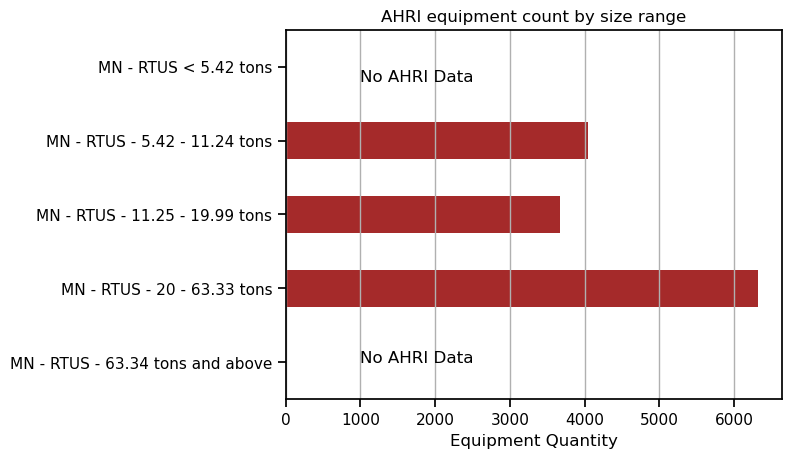

In [28]:
df['dx_units_category'].value_counts().loc[labels[:-1][::-1]].plot(kind='barh', color='brown')
plt.title('AHRI equipment count by size range')
plt.grid(axis='x')
plt.xlabel('Equipment Quantity')
plt.yticks(ticks=range(-1,4), labels=labels[::-1])
plt.annotate('No AHRI Data',xy=(1000,2.8),xycoords='data',xytext=(1000,2.8))
plt.annotate('No AHRI Data',xy=(1000,-1),xycoords='data',xytext=(1000,-1))
plt.ylim(-1.5,3.5)
plt.show()

#### Unitary Equipment < 65,000 BTUH (5.42 tons) is not certified by AHRI
And there is no data from AHRI for this size range to be used in this analysis.
https://www.ahrinet.org/App_Content/ahri/files/Certification/OM%20pdfs/ULE_OM.pdf

#### Unitary Equipment > 760,000 BTUH (63.33 tons) is not certified by AHRI
And there is no data from AHRI for this size range to be used in this analysis.
https://www.ahrinet.org/App_Content/ahri/files/Certification/OM%20pdfs/ULE_OM.pdf

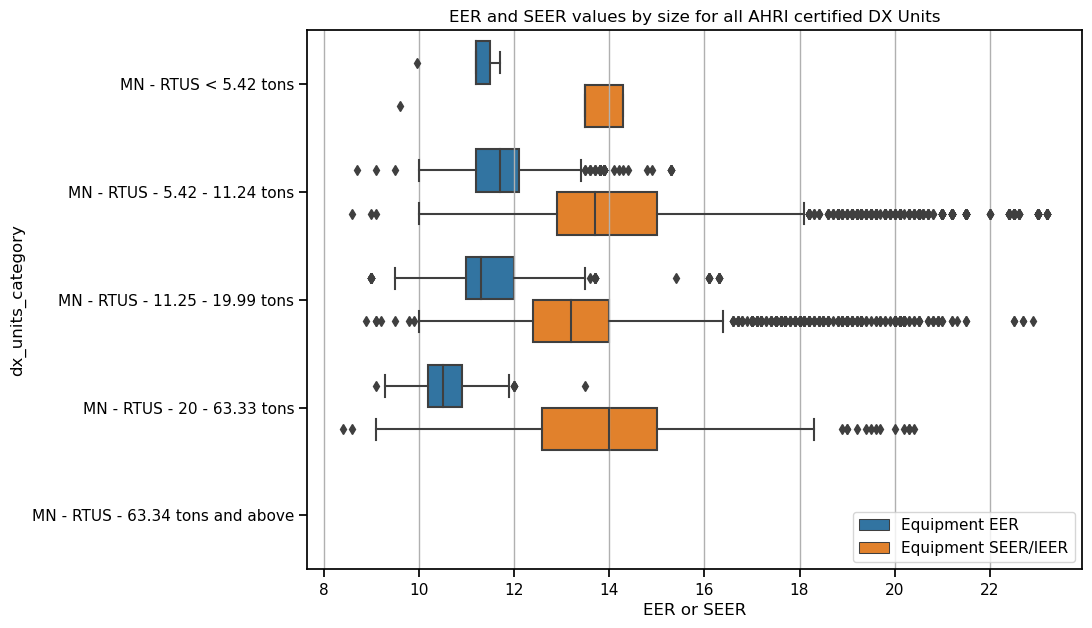

In [29]:
df_EER_SEER_melt = df[['Equipment SEER/IEER','Equipment EER',
                       'dx_units_category']].melt(id_vars='dx_units_category',
                                                  value_name='EER or SEER')
plt.figure(figsize=(10,7))
sns.boxplot(data=df_EER_SEER_melt, y='dx_units_category', x='EER or SEER',
            hue='variable', hue_order=['Equipment EER','Equipment SEER/IEER'],order=labels)
# sns.swarmplot(data=df_EER_SEER_melt, y='dx_units_category', x='EER or SEER',
#             hue='variable', hue_order=['Equipment EER','Equipment SEER/IEER'],order=labels)
plt.grid(axis='x')
plt.title('EER and SEER values by size for all AHRI certified DX Units')
plt.legend(loc='lower right')
plt.show()

### Load History of Cooling Efficiency Incentives
History will be used to understand distributions and subsequent weightings of "Building Type" and Equivalent Full-Load Hours (EFLH)

In [49]:
file_history = 'data/Cooling Incentive History.csv'
df_history = pd.read_csv(file_history)
df_history.head(3)

F_Measure_Type_Name__c   F_Equipment_Name_Proposed__c  I_EER_MC04__c  \
0          Cool EER-SEER  MN - RTUS - 5.42 - 11.24 tons           12.8   
1          Cool EER-SEER  MN - RTUS - 5.42 - 11.24 tons           12.0   
2         Cool SEER - MN          MN - RTUS < 5.42 tons           12.0   

   P_Cooling_Hrs_mc4__c  i_Qty_Prop_Equip_mc__c  i_SEER_MC04__c  \
0                   563                       2            19.1   
1                   563                       1            13.0   
2                   563                       1            16.0   

   i_unit_cooling_BTUH__c  i_unit_cooling_tons_mc__c County__c  \
0                     NaN                       7.42       NaN   
1                     NaN                       7.42       NaN   
2                     NaN                       3.92       NaN   

   Customer_Therms__c  ...  Uncapped_Electric_Rebate__c  \
0                 NaN  ...                      4704.28   
1                 NaN  ...                       756.84   
2                 NaN  ...                       466.48   

   Uncapped_Gas_Rebate__c  Units_Electric__c  Units_Gas__c     county__c  \
0                     0.0                  2             0  Hennepin MN3   
1                     0.0                  1             0  Hennepin MN3   
2                     0.0                  1             0  Hennepin MN3   

   eo3__Completion_Date__c  eo3__Eligible_Equipment_Type_1__c  AF_Date__c  \
0               2019-09-13                                NaN  2021-01-13   
1               2019-09-13                                NaN  2021-01-13   
2               2019-09-13                      Cool EER-SEER  2021-01-13   

              Name     i_Facility_Type__c  
0  OID4327679-0002  Education - Secondary  
1  OID4327679-0003  Education - Secondary  
2  OID4327679-0001  Education - Secondary  

[3 rows x 77 columns]

In [50]:
df_history['AF_Year'] = pd.to_datetime(df_history['AF_Date__c']).dt.year

In [51]:
df_history[['Name','F_Equipment_Name_Proposed__c','i_SEER_MC04__c','I_EER_MC04__c',
            'i_unit_cooling_tons_mc__c','Customer_kW__c','Customer_kWh__c']].head(5)

Name    F_Equipment_Name_Proposed__c  i_SEER_MC04__c  \
0  OID4327679-0002   MN - RTUS - 5.42 - 11.24 tons            19.1   
1  OID4327679-0003   MN - RTUS - 5.42 - 11.24 tons            13.0   
2  OID4327679-0001           MN - RTUS < 5.42 tons            16.0   
3  OID4484533-0002  MN - RTUS - 11.25 - 19.99 tons            13.0   
4  OID4484533-0001     MN - RTUS - 20 - 63.33 tons            12.5   

   I_EER_MC04__c  i_unit_cooling_tons_mc__c  Customer_kW__c  Customer_kWh__c  
0           12.8                       7.42           2.277             3703  
1           12.0                       7.42           0.675              620  
2           12.0                       3.92           0.337              382  
3           12.0                      16.50           3.667             3611  
4           11.6                      25.00           4.750             4110

Reduce history to only relevant & matching records

In [52]:
(df_history['i_Facility_Type__c'] == df_history['F_Equip_Building_Type__c']).value_counts()

True    4099
dtype: int64

In [53]:
df_history['F_Equipment_Name_Proposed__c'].isin(df_equipment['eo3__Equipment_Type__c']).value_counts()

True    4099
Name: F_Equipment_Name_Proposed__c, dtype: int64

Fill NaN values in I_EER using this conversion:   𝐸𝐸𝑅=𝑆𝐸𝐸𝑅×0.85

In [54]:
df_history.I_EER_MC04__c.isna().value_counts()

False    3611
True      488
Name: I_EER_MC04__c, dtype: int64

In [55]:
df_history.I_EER_MC04__c.fillna(df_history.i_SEER_MC04__c.apply(lambda x: x*0.85), inplace=True)

In [56]:
df_history.I_EER_MC04__c.isna().value_counts()

False    4099
Name: I_EER_MC04__c, dtype: int64

In [57]:
df_history[['Customer_kW__c','F_Net_Gen_kW__c','Customer_kWh__c','F_Net_Gen_kWh__c']].sample(5)

Customer_kW__c  F_Net_Gen_kW__c  Customer_kWh__c  F_Net_Gen_kWh__c
2142           0.603          0.58387              285            305.14
3251           1.611          1.55290             1433           1545.00
3278           1.611          1.55290            25661          27666.62
589           27.844         26.94516            43752          46843.68
3019           0.494          0.47742              644            689.51

#### Load EFLH table by Zone
EFLH is the total deemed full-load operating hours for a given facility type  and climate.

In [61]:
file_parameters = 'data/Cooling Incentive Parameters.csv'
df_calc_params = pd.read_csv(file_parameters)

In [63]:
df_calc_params.head(2)

Name   eo3__Type__c eo3__Value__c External_Identifier__c  \
0  B03_2 - Cooling  Cooling Hours           647   P_Cooling_Hrs_mc4__c   
1  B03_2 - Cooling  Cooling Hours           986   P_Cooling_Hrs_mc4__c   

  Application__c Central_Air_in_Home__c  Cooling_Type__c  \
0            NaN                  False              NaN   
1            NaN                  False              NaN   

  Equipment_Category__c Existing_Insulation__c   Facility_Type__c  ...  \
0                   NaN                  False  Convenience Store  ...   
1                   NaN                  False  Convenience Store  ...   

  State__c  Year__c Zone__c                   CreatedDate  eo3__Valid_From__c  \
0       MN      NaN     MN1  2017-02-04T16:13:38.000+0000          2017-01-01   
1       MN      NaN     MN3  2017-02-04T16:13:38.000+0000          2017-01-01   

  eo3__Valid_To__c                               eo3__Search_Pairs__c  \
0       2029-12-31  F_Equip_Building_Type__c=Facility_Type__c,F_Co...   
1       2029-12-31  F_Equip_Building_Type__c=Facility_Type__c,F_Co...   

                                eo3__Measure_Type__c Unnamed: 21 County_list  
0  Cooling Centrifugal v3,Cooling Centrifugal v3-...         NaN  Aitkin MN2  
1  Cooling Centrifugal v3,Cooling Centrifugal v3-...         NaN   Anoka MN3  

[2 rows x 23 columns]

In [64]:
df_EFLH_MN3 = df_calc_params.loc[(df_calc_params['eo3__Type__c'] == 'Cooling Hours') &
                                 (df_calc_params['Zone__c'] == 'MN3'),
                                 ['Facility_Type__c','eo3__Value__c','Zone__c']]\
                                .set_index('Facility_Type__c', drop=True)
df_EFLH_MN3.head(5)

eo3__Value__c Zone__c
Facility_Type__c                                              
Convenience Store                                  986     MN3
Data Center                                      8,760     MN3
Education - Community College/University           785     MN3
Education - Primary                                408     MN3
Education - Secondary                              563     MN3

#### Data loading complete!

## What are DX Units?
Cooling only
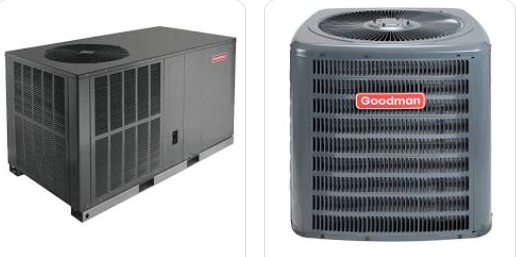
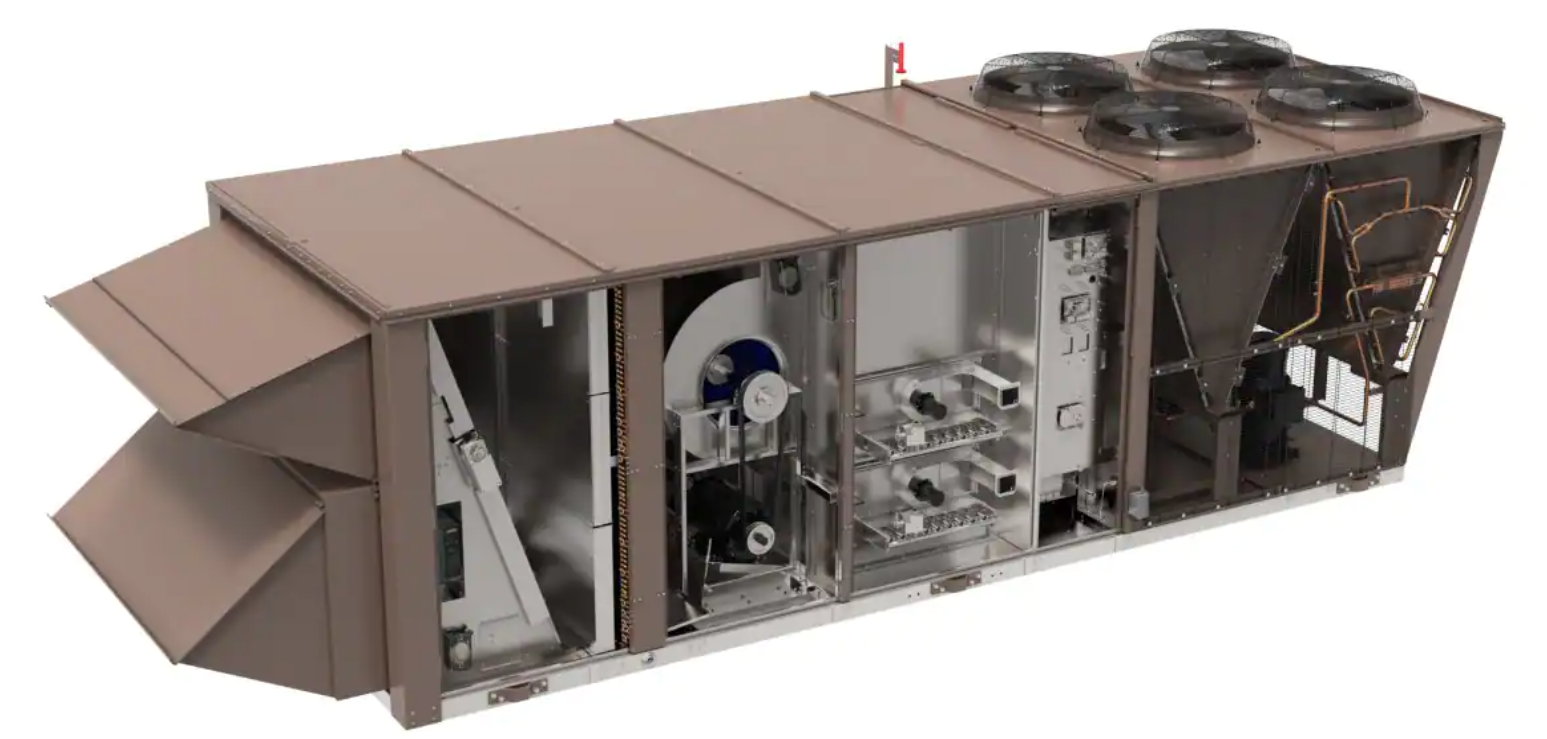

### Definitions
DX = Direct Expansion (heat is transferred 'directly' from refrigerant to air - no intermediate fluid)

EER = Full load cooling efficiency 
    (higher number = more efficient)
    
SEER (IEER) = Part-load cooling efficiency 
    (higher number = more efficient)
    
Tons = Cooling Capacity (equal to 12,000 BTUH)
    A typical MN home is 1-2 tons of capacity
    
EFLH = Equivalent Full Load Hours (cooling hours per year)
    
EER/SEER Baseline = Minimum Efficiency permitted by building code

Minimum Qualifying EER/SEER = Arbitrary minimum qualifying levels set by utility

Avoided Revenue Requirement (ARR) = Monetary benefit to Utility derived from projected savings

C:\Users\237525\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Figure size 1000x1000 with 0 Axes>

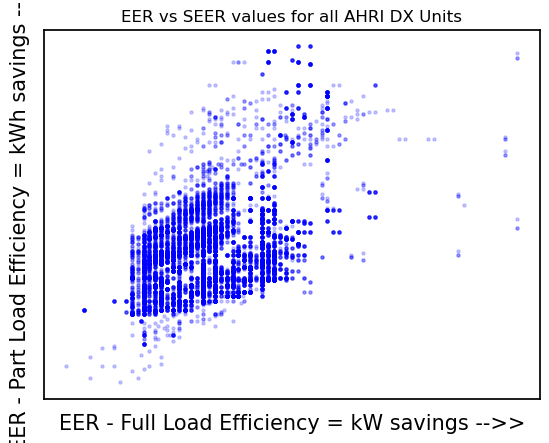

In [65]:
plt.figure(figsize=(10,10))
df.plot(kind='scatter', x='Equipment EER', y='Equipment SEER/IEER', alpha=0.2,
        marker='.', color='blue')
plt.title('EER vs SEER values for all AHRI DX Units')
plt.xlabel('EER - Full Load Efficiency = kW savings -->>', fontsize=15)
plt.ylabel('SEER - Part Load Efficiency = kWh savings -->>', fontsize=15)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.grid(axis='both')
plt.show()

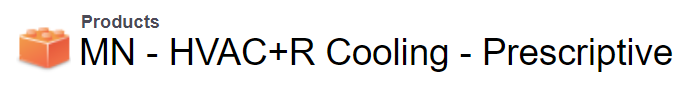

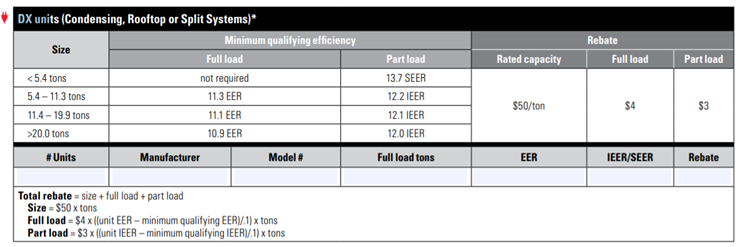

## What is the Historical Significance of DX Units for Incentive Program?

In [67]:
sns.set_context('talk')
product = "MN - HVAC+R Cooling - Prescriptive"
before_2021 = df_history['AF_Year'] < 2021
df_performance_by_year = df_history.loc[before_2021].groupby(
        by=['AF_Year','F_Equipment_Name_Proposed__c']).agg({'Name':'count',
                                                        'I_Qty_Prop_Equip__c':sum,
                                                       'i_unit_cooling_tons_mc__c':'mean',
                                                        'I_EER_MC04__c':'mean',
                                                        'i_SEER_MC04__c':'mean',
                                                         'P_Cooling_Hrs_mc4__c':'mean',
                                                            'Customer_kWh__c':sum,
                                                           'Customer_kW__c':sum
                                                       })
df_performance_by_year.rename(columns={'Name':'Participants'}, inplace=True)
# df_performance_by_year
savings_metrics = ['Customer_kWh__c','Customer_kW__c','Participants']
df_perf_year_melt = df_performance_by_year.reset_index()

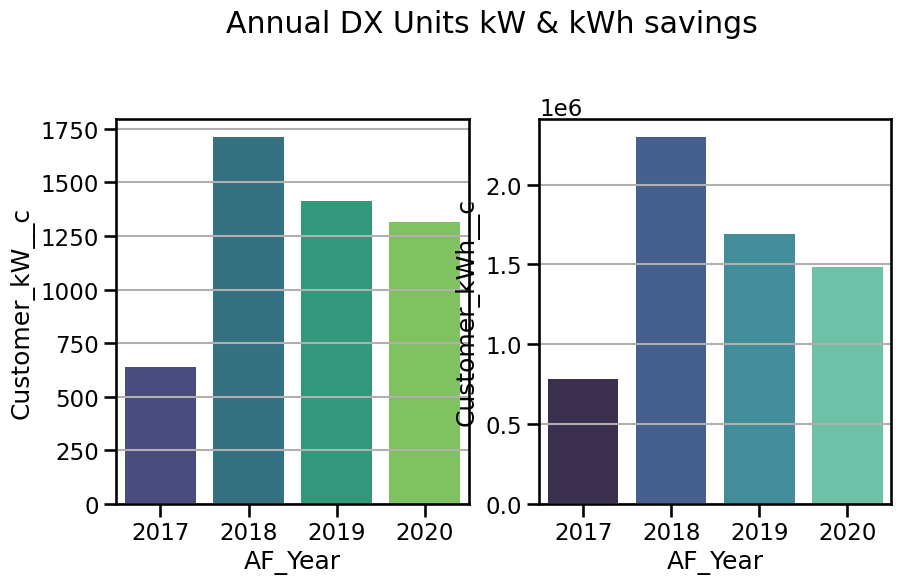

In [68]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5))
sns.barplot(data=df_perf_year_melt.groupby('AF_Year').sum().reset_index(),
            x='AF_Year',y='Customer_kW__c', ax=ax1, palette="viridis",)
sns.barplot(data=df_perf_year_melt.groupby('AF_Year').sum().reset_index(),
            x='AF_Year',y='Customer_kWh__c', ax=ax2, palette="mako")
ax1.grid(axis='y')
ax2.grid(axis='y')
plt.suptitle('Annual DX Units kW & kWh savings', y=1.1)
plt.show()

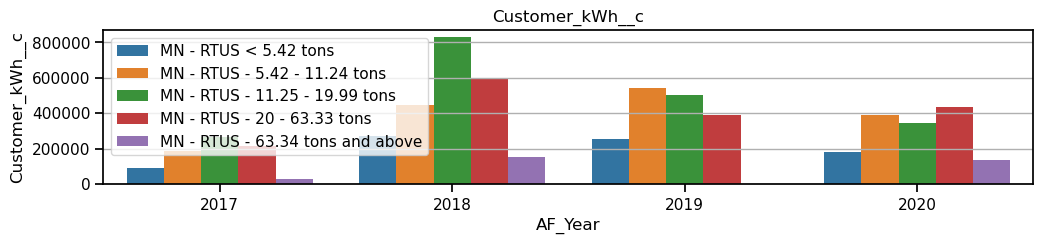

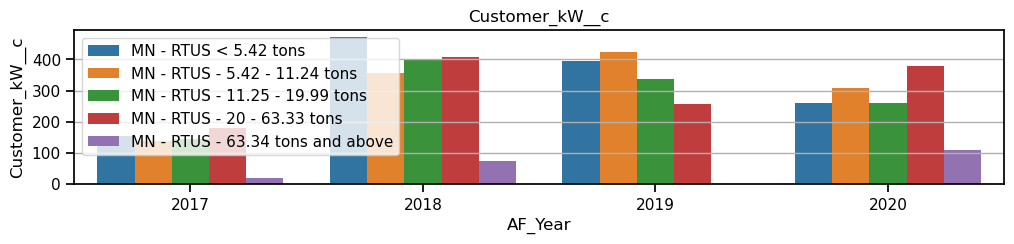

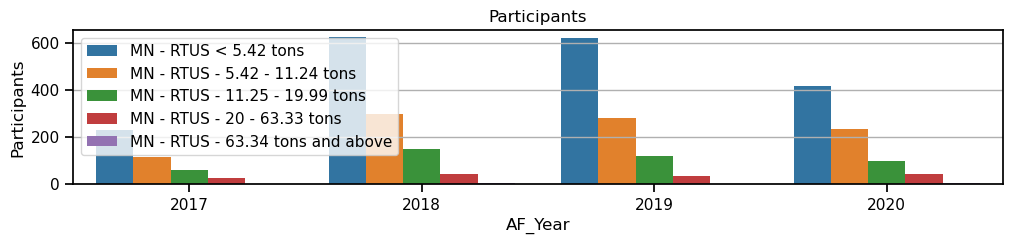

In [70]:
sns.set_context('notebook')
for savings_category in savings_metrics:
    plt.figure(figsize=(12,2))
    plt.title(f'{savings_category}')
    sns.barplot(data=df_perf_year_melt, x='AF_Year',y=f'{savings_category}', hue='F_Equipment_Name_Proposed__c', hue_order=labels )
    plt.grid(axis='y')
    plt.legend(loc='upper left')
fig.suptitle(f'Annual Achievement for DX Units in {product}')    
plt.show()

In [75]:
df_history_summary = df_history.groupby('F_Equipment_Name_Proposed__c').agg({'Name':'count',
                                                        'I_Qty_Prop_Equip__c':sum,
                                                       'i_unit_cooling_tons_mc__c':'mean',
                                                        'I_EER_MC04__c':'mean',
                                                        'i_SEER_MC04__c':'mean',
                                                         'P_Cooling_Hrs_mc4__c':'mean'
                                                       }).loc[labels]
df_history_summary.rename(columns={'Name':'Participants'}, inplace=True)
# df_history_summary

## What is the Opportunity?

### Trade partners frustrated about rejection of equipment that significantly exceeds SEER requirements but barely fails EER requirement - no rebate, no savings acheivement

In [76]:
def style_false(v, props=''):
    return props if v == False else None
def style_true(v, props=''):
    return props if v == True else None
cols = ['Model Number','Unit Size (Tons)','Equipment SEER/IEER','Min_SEER__c','qualified_SEER',
        'Equipment EER','Min_EER__c', 'qualified_EER']
df.loc[(df['Equipment SEER/IEER'] > 15) & df['qualified_SEER'] & ~df['qualified_EER'], cols].round(1).sample(3).set_index('Model Number',drop=True).style.applymap(style_false, props='color:red;').applymap(style_true, props='color:green;')

## Levers to Pull
Which inputs and parameters in the prescriptive measure can be changed?

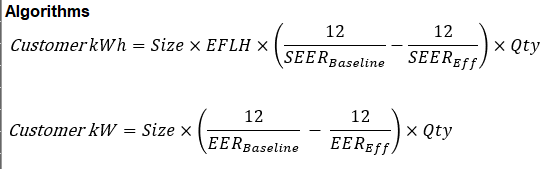

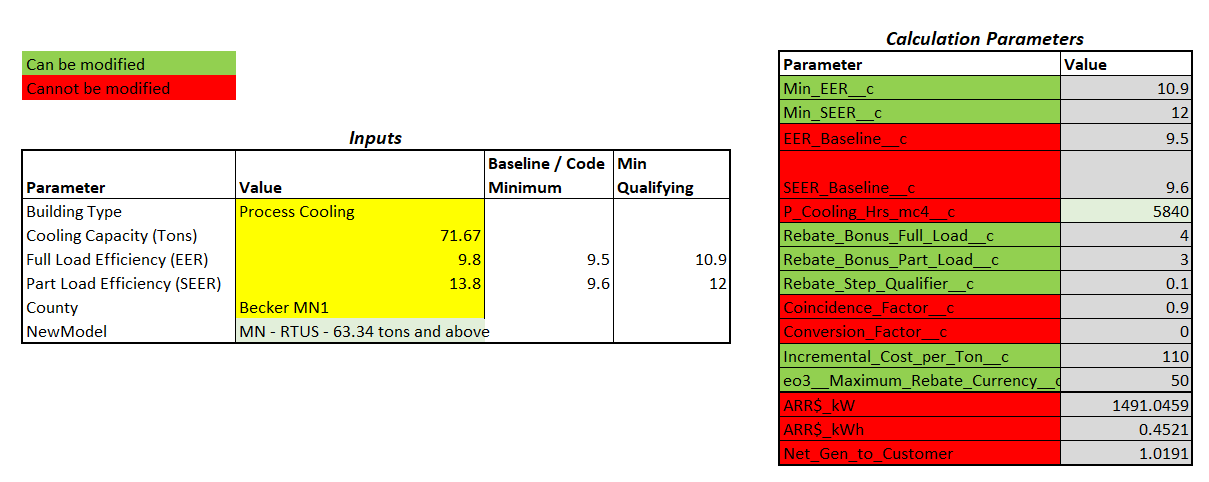

### Flexible Minimum Qualifying overview
The flexible minimum qualifying concept increases the range of qualified DX Unit equipment by accepting equipment with lower EERs (full-load efficiency) and higher SEERs (part-load efficiency).  The concept uses a single result, Total Electric Avoided Revenue Requirement (ARR), to determine if candidate equipment results in more Total Electric ARR than would occur under the current minimum qualifying rules.

### ARR = Net_kW_savings * ARR/kW  +  Net_kWh_savings * ARR/kWh
For MN Cooling:<BR>
    ARR/kW = 1491<BR>
    ARR/kWh = 0.452

### Why not simply lower minimum qualifying EER and SEER values?  Cost Effectiveness
EER and SEER efficiencies have disproportionate impacts on Utility Benefits and must not be considered in isolation.

### How does DX Unit qualification work now?

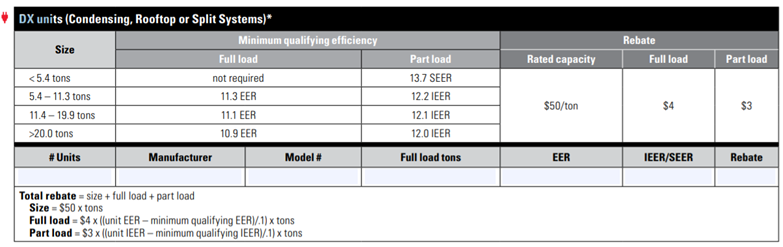

### Determine "Total Utility Electric ARR" values
Total Electric Utility ARR is a function of Customer kW and kWh savings multiplied by net generation  and Utility ARR/kW and ARR/kWh multipliers.  The Minimum Utility Electric ARR is proposed in this analysis as an alternative minimum qualifying criteria in place of the standard fixed minimum qualifying EER and SEER values.  In other words, instead of judging the qualification of a new equipment application based on efficiency levels, the passing criteria will be Minimum Utility Electric ARR.  However, the goal is to maintain the appearance and simplicity of using the EER and SEER values, but now those EER and SEER values will be set based on Minimum Utility Electric ARR.   The Minimum Utility Electric ARR needs to be determined for each combination of Equipment type, location and Facility Type.  Note that due to the overwhelming dominance of historical measures in the 'MN3' location, only this location will be analyzed and MN1, MN2 will be overlooked.  Also, Equipment Capacity has a linear relationship with Minimum Utility Electric ARR, so the effect of Equipment capac  

#### Calculating Customer kW & kWh values requires:
1. location
2. Facility Type
3. Proposed & Baseline efficiency levels
4. Equipment capacity

### Define functions to calculate ARR

In [77]:
def customer_kW_DX(EER_Baseline__c, I_EER_MC04__c, i_unit_cooling_tons_mc__c, I_Qty_Prop_Equip__c):
    return round(((12/EER_Baseline__c)-(12/I_EER_MC04__c))*i_unit_cooling_tons_mc__c,3)

In [78]:
customer_kW_DX(11, 13, 5, 1)

0.839

In [79]:
def P_Cooling_Hrs_mc4(i_Facility_Type__c, df=df_EFLH_MN3):
    return df.loc[i_Facility_Type__c,'eo3__Value__c']

In [80]:
P_Cooling_Hrs_mc4('Restaurant')

'652'

In [81]:
def customer_kWh_DX(SEER_Baseline__c, i_SEER_MC04__c, i_unit_cooling_tons_mc__c, I_Qty_Prop_Equip__c, P_Cooling_Hrs_mc4__c):
#     return ((12/EER_Baseline__c)-(12/I_EER_MC04__c))*i_unit_cooling_tons_mc__c
#     return int(round(((12/SEER_Baseline__c)-(12/i_SEER_MC04__c))*i_unit_cooling_tons_mc__c*I_Qty_Prop_Equip__c*P_Cooling_Hrs_mc4__c,0))
    return round(((12/SEER_Baseline__c)-(12/i_SEER_MC04__c))*i_unit_cooling_tons_mc__c*I_Qty_Prop_Equip__c*P_Cooling_Hrs_mc4__c,0)

In [82]:
customer_kWh_DX(11,15,10,1,1000)

2909.0

### Changed net Gen calculations - 6-24-21

In [83]:
def net_gen_kWh_savings(energy_savings, Customer_to_Net_Gen = 1.01911236580832):
    if type(energy_savings) == int:
#         response = int(energy_savings/Customer_to_Net_Gen)
        response = int(energy_savings*Customer_to_Net_Gen)
    else:
#         response = round(energy_savings/Customer_to_Net_Gen,3)
        response = round(energy_savings*Customer_to_Net_Gen,3)
    return response

In [84]:
def net_gen_kW_savings(energy_savings, Customer_to_Net_Gen = 1.01911236580832):
    if type(energy_savings) == int:
        response = int(energy_savings/Customer_to_Net_Gen)
#         response = int(energy_savings*Customer_to_Net_Gen)
    else:
        response = round(energy_savings/Customer_to_Net_Gen,3)
#         response = round(energy_savings*Customer_to_Net_Gen,3)
    return response

In [85]:
net_gen_kWh_savings(10.555)

10.757

In [86]:
net_gen_kW_savings(10.555)

10.357

In [87]:
def utility_electric_kW_ARR(net_gen_kW, ARR_kW = 1491.04593569493):
    return round(net_gen_kW*ARR_kW,2)

In [88]:
utility_electric_kW_ARR(0.823)

1227.13

In [89]:
def utility_electric_kWh_ARR(net_gen_kWh, ARR_kWh = 0.452115074609045):
    return round(net_gen_kWh*ARR_kWh,2)

In [90]:
utility_electric_kWh_ARR(2854)

1290.34

In [91]:
def utility_electric_ARR(utility_electric_kW_ARR,utility_electric_kWh_ARR):
    return round(sum([utility_electric_kW_ARR,utility_electric_kWh_ARR]),2)

In [92]:
utility_electric_ARR(1227.131,1290)

2517.13

In [93]:
def utility_ARR(EER_Baseline__c, I_EER_MC04__c,SEER_Baseline__c, i_SEER_MC04__c, i_unit_cooling_tons_mc__c,I_Qty_Prop_Equip__c, P_Cooling_Hrs_mc4__c):
    return utility_electric_ARR(utility_electric_kW_ARR(net_gen_kW_savings(customer_kW_DX(EER_Baseline__c, I_EER_MC04__c,i_unit_cooling_tons_mc__c, I_Qty_Prop_Equip__c))),
                         utility_electric_kWh_ARR(net_gen_kWh_savings(customer_kWh_DX(SEER_Baseline__c, i_SEER_MC04__c, i_unit_cooling_tons_mc__c,I_Qty_Prop_Equip__c, P_Cooling_Hrs_mc4__c))))
    

In [94]:
utility_ARR(9.8,10,9.9,13.5,40.83,1,622)

5245.07

## Visualize EER & SEER of DX Units in AHRI database
Objectives:<BR>
    1. Visualize coincidence of two dimensions<BR>
    2. Could there be significant gains in potential participation that don't harm cost-effectiveness?

In [95]:
dx_unit = labels[1:2][0]

(9.0, 18.0)

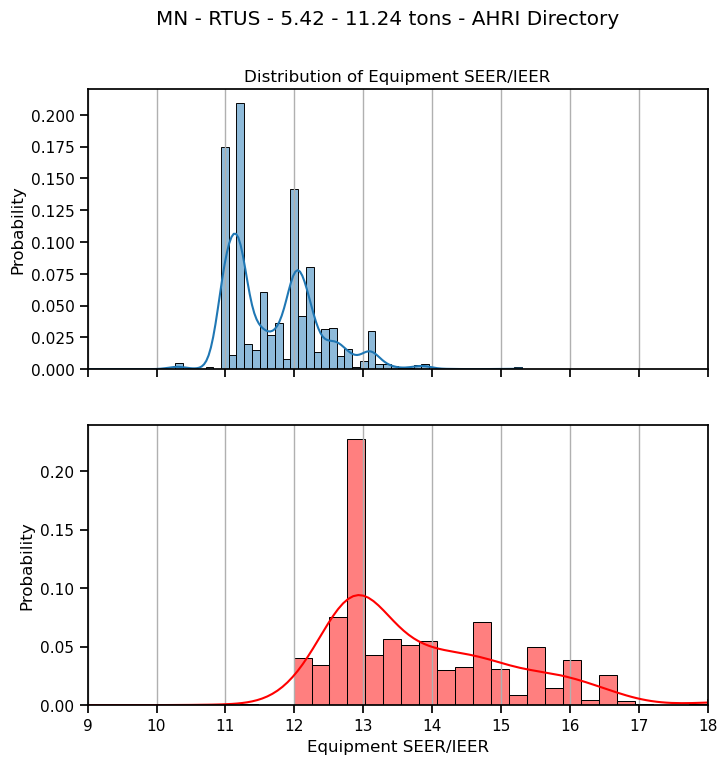

In [96]:
fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize = (8,8))
ax1 = sns.histplot(data=df.loc[df['dx_units_category'] == dx_unit], x='Equipment EER', ax=ax1, stat='probability', kde=True)
ax1.grid(axis='x')
ax1.set_title('Distribution of Equipment EER')
plt.suptitle(f'{dx_unit} - AHRI Directory')

ax2 = sns.histplot(data=df.loc[df['dx_units_category'] == dx_unit], x='Equipment SEER/IEER', color='red', ax= ax2, stat='probability', kde=True)
ax2.grid(axis='x')
ax1.set_title('Distribution of Equipment SEER/IEER')
# plt.title(f'{dx_unit}')
plt.xlim(9, 18)

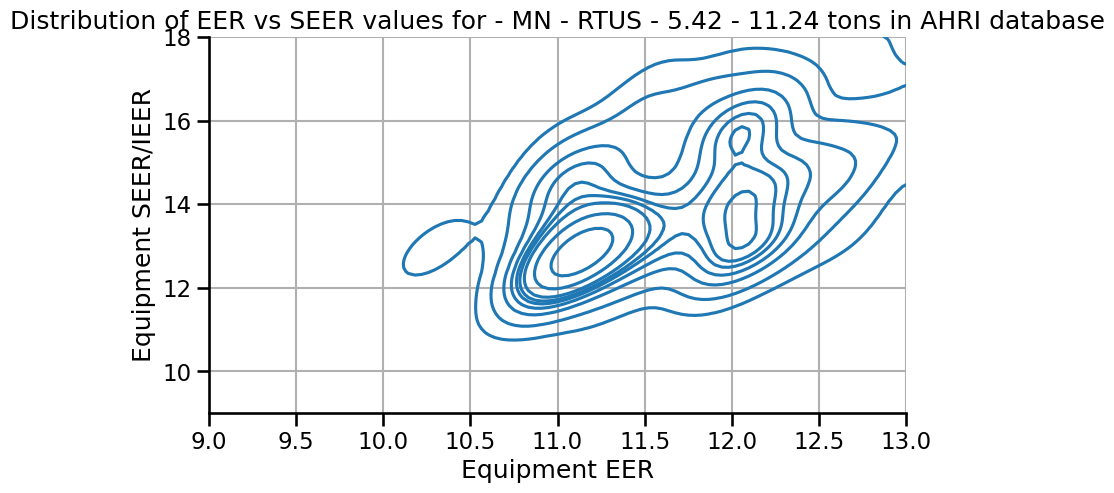

In [97]:
sns.set_context('talk')
# for dx_unit in dx_unit[:]:
#     SEER_baseline = float(df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == dx_unit, 'SEER_Baseline__c'] )
#     EER_baseline = float(df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == dx_unit, 'EER_Baseline__c'])
#     Min_SEER = df.loc[df['dx_units_category']==dx_unit,'Min_SEER__c'].unique()[0]
#     Min_EER = df.loc[df['dx_units_category']==dx_unit,'Min_EER__c'].unique()[0]
sns.displot(data = df.loc[df['dx_units_category'] == dx_unit], x='Equipment EER',
            y='Equipment SEER/IEER', kind='kde', height=5, aspect=1.7)
plt.title(f'Distribution of EER vs SEER values for - {dx_unit} in AHRI database')
plt.xlim(9,13)
plt.ylim(9,18)
plt.grid(axis='both')
plt.margins(0.9)
plt.show()

### Minimum qualifying values & Code Minimum

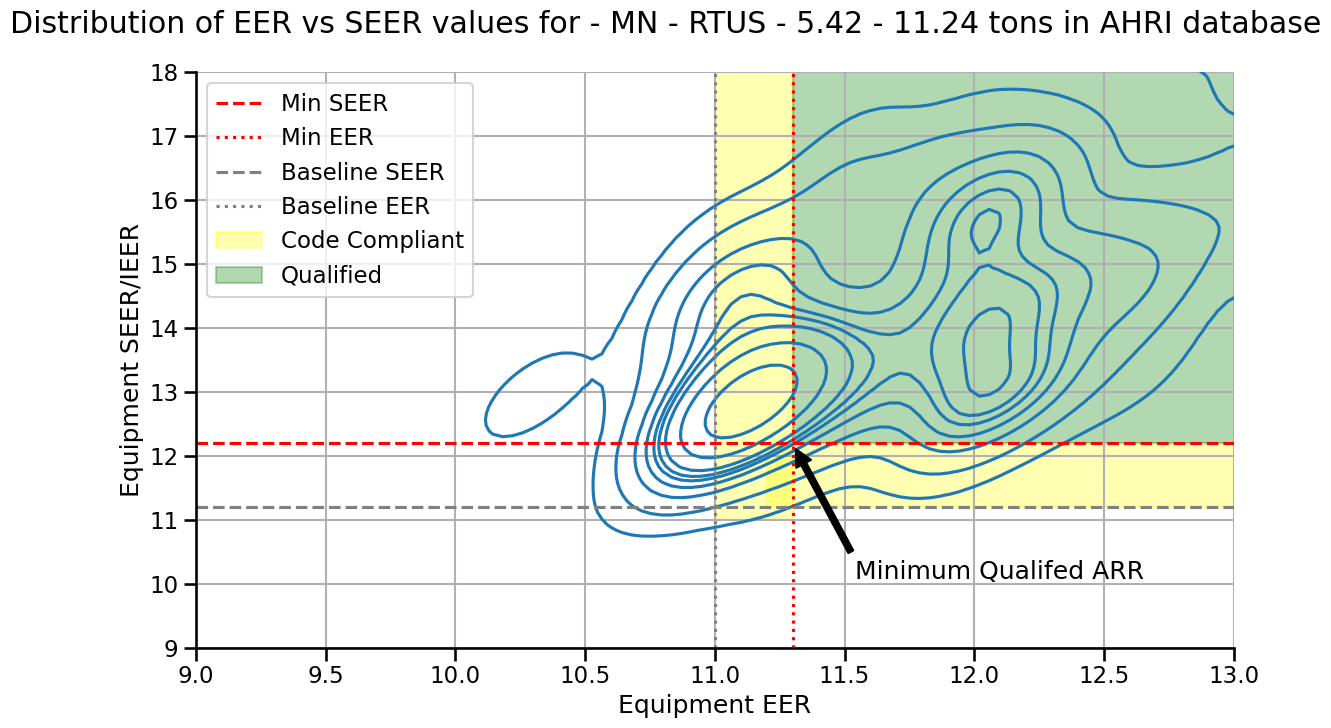

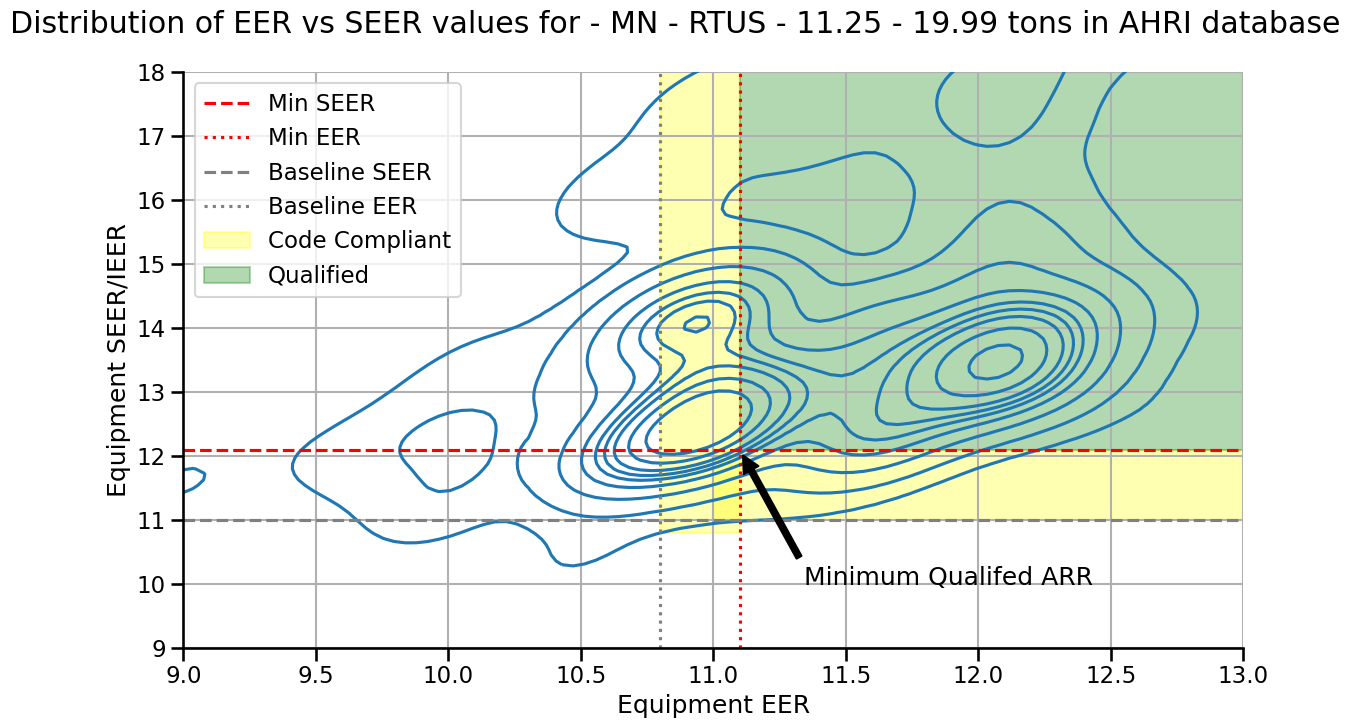

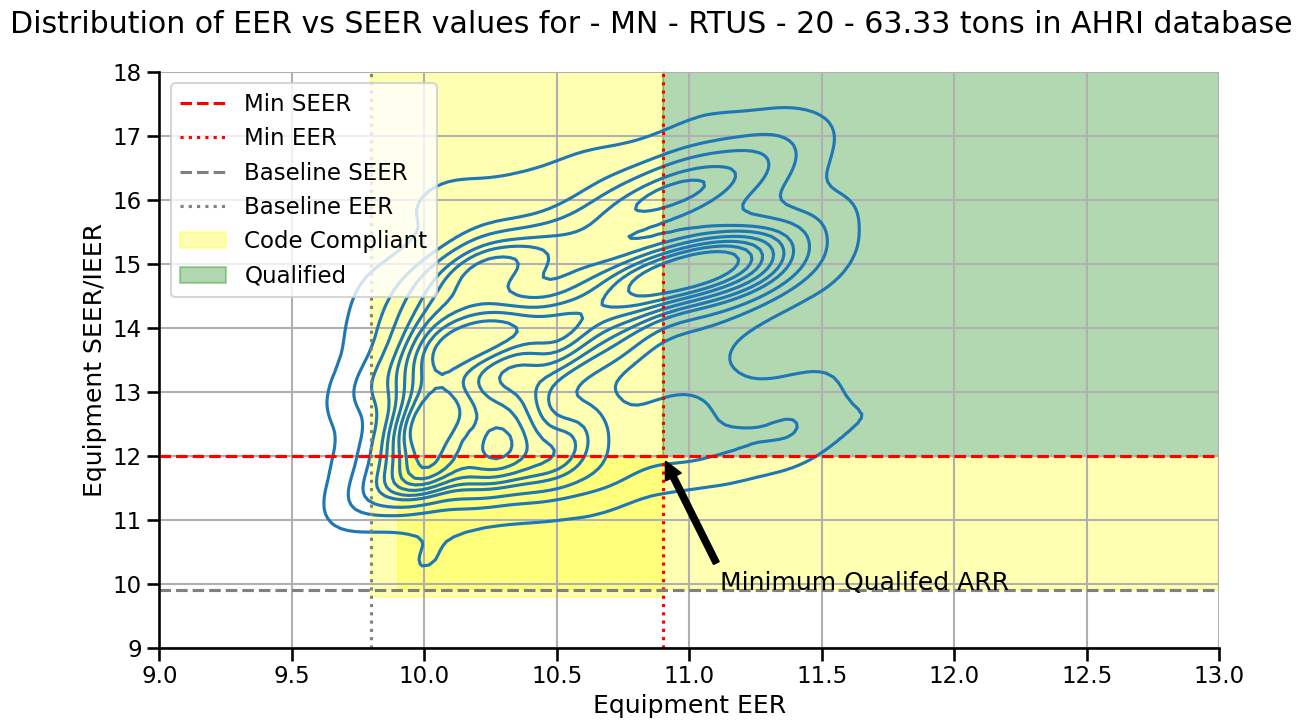

In [98]:
sns.set_context('talk')
# for dx_unit in ['MN - RTUS - 5.42 - 11.24 tons','MN - RTUS - 11.25 - 19.99 tons', 'MN - RTUS - 20 - 63.33 tons'][:1]:
for dx_unit in labels[1:4]:
    SEER_baseline = float(df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == dx_unit, 'SEER_Baseline__c'] )
    EER_baseline = float(df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == dx_unit, 'EER_Baseline__c'])
    Min_SEER = df.loc[df['dx_units_category']==dx_unit,'Min_SEER__c'].unique()[0]
    Min_EER = df.loc[df['dx_units_category']==dx_unit,'Min_EER__c'].unique()[0]
    sns.displot(data = df.loc[df['dx_units_category'] == dx_unit], x='Equipment EER',
                y='Equipment SEER/IEER', kind='kde', height=7, aspect=1.7)
    plt.hlines(Min_SEER,9,13, linestyle='--', colors='red', label='Min SEER')
    plt.vlines(Min_EER,9,18, linestyle='dotted', colors='red', label='Min EER')
    
    plt.hlines(SEER_baseline,9,13, linestyle='--', colors='gray', label='Baseline SEER')
    plt.vlines(EER_baseline,9,18, linestyle='dotted', colors='gray', label='Baseline EER')
    plt.suptitle(f'Distribution of EER vs SEER values for - {dx_unit} in AHRI database', y=1.05)
    plt.axvspan(EER_baseline, Min_EER, ymin=(EER_baseline-9)/(18-9), alpha=0.3, color='yellow')
    plt.axhspan(SEER_baseline, Min_SEER, xmin=(SEER_baseline-9)/(13-9), alpha=0.3, color='yellow', label='Code Compliant')
    plt.axvspan(Min_EER,13, color='green',ymin=(Min_SEER-9)/(18-9), alpha=0.3, label='Qualified')
#     plt.annotate()
    plt.annotate('Minimum Qualifed ARR', xy=(Min_EER, Min_SEER),  xycoords='data',
            xytext=(Min_EER*1.12, Min_SEER*0.85), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
            
    plt.xlim(9,13)
    plt.ylim(9,18)
    plt.grid(axis='both')
    plt.legend(loc='upper left')
    plt.margins(0.9)
    plt.show()

### How many unqualified equipment models are there? 
Equipment models that comply with code but do not meet minimum qualifying criteria 

In [99]:
total_models, code_compliant_models, qualified_models = [], [], []
code_compliant_equipment = (df['Equipment EER'] > df['EER_Baseline__c']) & (df['Equipment SEER/IEER'] > df['SEER_Baseline__c'])
qualified_equipment = (df['Equipment EER'] > df['Min_EER__c']) & (df['Equipment SEER/IEER'] > df['Min_SEER__c'])

for dx_unit in labels:
    total_models_ = len(df.loc[(df['dx_units_category'] == dx_unit)])
    code_compliant_models_ = len(df.loc[code_compliant_equipment & (df['dx_units_category'] == dx_unit)])
    qualified_models_ = len(df.loc[qualified_equipment & (df['dx_units_category'] == dx_unit)])
    total_models.append(total_models_)
    code_compliant_models.append(code_compliant_models_)
    qualified_models.append(qualified_models_)
df_qualified_by_model = pd.DataFrame(index=labels, data={'total models':total_models,
                                'code_compliant_models':code_compliant_models,
                                'qualified_models':qualified_models})

In [100]:
df_qualified_by_model['potential models'] = df_qualified_by_model['code_compliant_models'] - df_qualified_by_model['qualified_models']

In [101]:
# dictionary of column colors
coldict = {'code_compliant_models':'yellow', 'qualified_models':'green'}

def highlight_cols(s, coldict):
    if s.name in coldict.keys():
        return ['background-color: {}'.format(coldict[s.name])] * len(s)
    return [''] * len(s)

df_qualified_by_model.replace(0,'No Data').style.apply(highlight_cols, coldict=coldict)

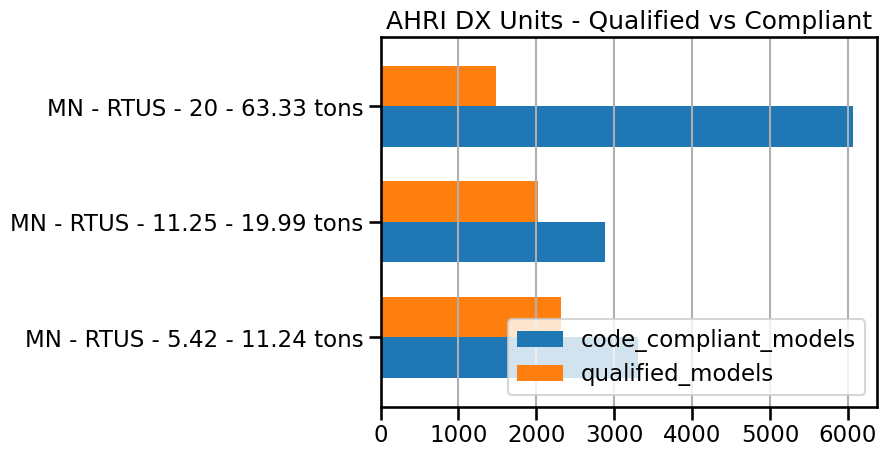

In [102]:
df_qualified_by_model[['code_compliant_models','qualified_models']][1:-1].plot(kind='barh', width=0.7)
plt.yticks(np.arange(3),labels[1:-1])
# sns.barplot(data = df_qualified_by_model[1:-1], y='Manufacturer', x='Passing',hue='Criteria', ci=False,order=manufacturer_volume_sort_order[:15])
plt.legend(loc='lower right')
plt.grid(axis='x')
plt.title('AHRI DX Units - Qualified vs Compliant')
plt.show()

# Solution:

## Flexible Minimum qualifying - Accept any combination of EER & SEER if:
1. It results in ARR/Ton greater than the current standard criteria
2. It complies with code 

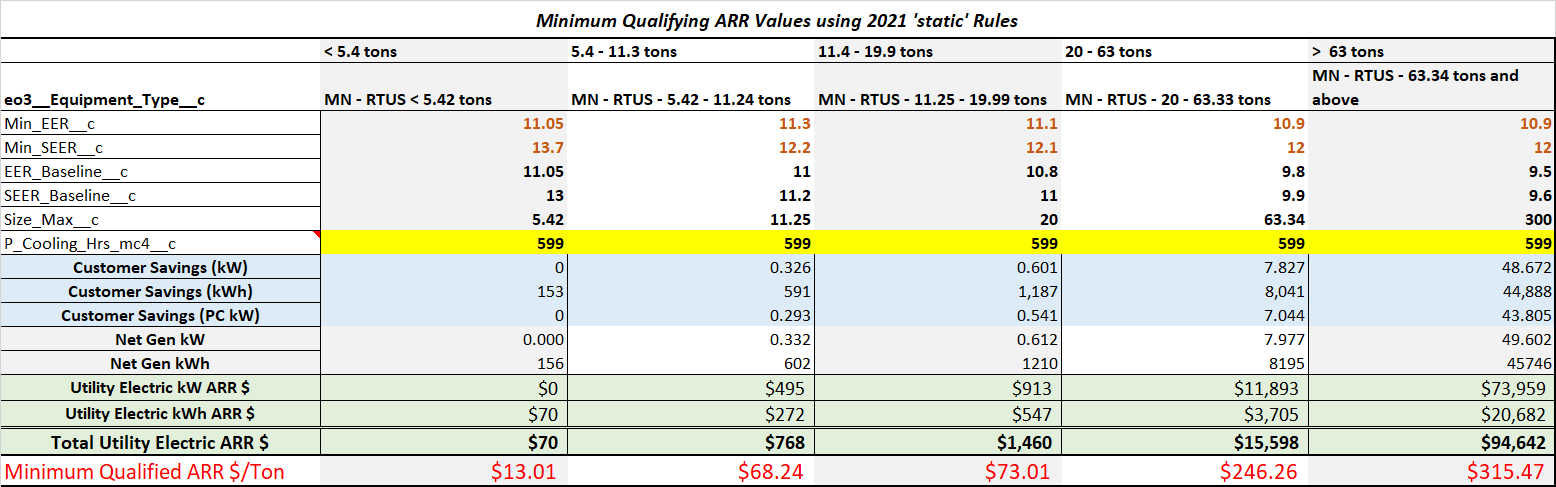

Current ARR$/Ton values are significantly different across size ranges - this should be optimized in the future.

### Calculate ARR
a one-dimensional metric for a two dimensional criteria

### Need to deem EFLH value that is representative for most cases

In [103]:
print('EFLH Historical Statistics\n')
EFLH = df_history.groupby('F_Equipment_Name_Proposed__c')['P_Cooling_Hrs_mc4__c'].describe().loc[:,'50%'].mean()
display(df_history.groupby('F_Equipment_Name_Proposed__c')['P_Cooling_Hrs_mc4__c'].describe().loc[:,['mean','50%']].astype('int'))
print(f'The mean of median EFLH values by Equipment Type is {EFLH}')

EFLH Historical Statistics



mean  50%
F_Equipment_Name_Proposed__c               
MN - RTUS - 11.25 - 19.99 tons     786  589
MN - RTUS - 20 - 63.33 tons        820  589
MN - RTUS - 5.42 - 11.24 tons      621  588
MN - RTUS - 63.34 tons and above  1089  652
MN - RTUS < 5.42 tons              600  574

The mean of median EFLH values by Equipment Type is 598.5


In [104]:
cols = ['EER_Baseline__c','Equipment EER','SEER_Baseline__c','Equipment SEER/IEER',
    'Unit Size (Tons)']
df[cols].iloc[8600:8602]

EER_Baseline__c  Equipment EER  SEER_Baseline__c  Equipment SEER/IEER  \
8600              9.8           10.0               9.9                 13.5   
8601              9.8           10.0               9.9                 13.5   

      Unit Size (Tons)  
8600         40.833333  
8601         40.833333

In [105]:
utility_ARR(9.8,10,9.9,13.5,40.83,1,EFLH)

5102.23

In [106]:
df['one'] = 1
df['P_Cooling_Hrs_mc4__c'] = EFLH

In [107]:
df['ARR'] = df.apply(lambda x: utility_ARR(x['EER_Baseline__c'], x['Equipment EER'], x['SEER_Baseline__c'], x['Equipment SEER/IEER'], x['Unit Size (Tons)'], x['one'], x['P_Cooling_Hrs_mc4__c']), axis=1)

In [108]:
df['ARR/Ton'] = df['ARR']/df['Unit Size (Tons)']

In [109]:
df[['P_Cooling_Hrs_mc4__c','ARR','ARR/Ton','Equipment SEER/IEER','Equipment EER','eo3__Equipment_Type__c']]

P_Cooling_Hrs_mc4__c      ARR     ARR/Ton  Equipment SEER/IEER  \
0                     598.5  1436.41  118.061096                 14.6   
1                     598.5  -899.75  -73.952055                 12.0   
2                     598.5 -5820.03 -311.787321                 11.6   
3                     598.5 -5558.57 -311.695514                 11.6   
4                     598.5 -2290.87 -114.543500                 11.6   
...                     ...      ...         ...                  ...   
14041                 598.5  -572.59 -264.272308                  9.6   
14042                 598.5   167.44   30.912000                 13.5   
14043                 598.5   167.44   30.912000                 13.5   
14044                 598.5   462.31   85.349538                 14.3   
14045                 598.5   603.96  111.500308                 14.3   

       Equipment EER          eo3__Equipment_Type__c  
0              11.10  MN - RTUS - 11.25 - 19.99 tons  
1              10.18  MN - RTUS - 11.25 - 19.99 tons  
2               8.99  MN - RTUS - 11.25 - 19.99 tons  
3               8.99  MN - RTUS - 11.25 - 19.99 tons  
4              10.00  MN - RTUS - 11.25 - 19.99 tons  
...              ...                             ...  
14041           9.96           MN - RTUS < 5.42 tons  
14042          11.20           MN - RTUS < 5.42 tons  
14043          11.20           MN - RTUS < 5.42 tons  
14044          11.50           MN - RTUS < 5.42 tons  
14045          11.70           MN - RTUS < 5.42 tons  

[14046 rows x 6 columns]

### What is the ARR/Ton of the current standard criteria?

In [110]:
df_equipment[['eo3__Equipment_Type__c','Size_Min__c','Size_Max__c','Min_SEER__c','SEER_Baseline__c','Min_EER__c','EER_Baseline__c']]

eo3__Equipment_Type__c  Size_Min__c  Size_Max__c  Min_SEER__c  \
0             MN - RTUS < 5.42 tons         0.00         5.42         13.7   
1     MN - RTUS - 5.42 - 11.24 tons         5.42        11.25         12.2   
2    MN - RTUS - 11.25 - 19.99 tons        11.25        20.00         12.1   
3       MN - RTUS - 20 - 63.33 tons        20.00        63.34         12.0   
4  MN - RTUS - 63.34 tons and above        63.34       300.00         12.0   

   SEER_Baseline__c  Min_EER__c  EER_Baseline__c  
0              13.0       11.05            11.05  
1              11.2       11.30            11.00  
2              11.0       11.10            10.80  
3               9.9       10.90             9.80  
4               9.6       10.90             9.50

In [111]:
df_equipment['Min_to_Baseline_delta_SEER'] = df_equipment['Min_SEER__c'] - df_equipment['SEER_Baseline__c']

df_equipment['Min_to_Baseline_delta_EER'] = df_equipment['Min_EER__c'] - df_equipment['EER_Baseline__c']

In [112]:
df_equipment['ARR/Ton'] = df_equipment.apply(lambda x: round(utility_ARR(x['EER_Baseline__c'], x['Min_EER__c'], x['SEER_Baseline__c'], x['Min_SEER__c'], x['Size_Max__c'], 1, EFLH)/x['Size_Max__c'],2), axis=1)
# df_equipment['ARR/Ton'] = df_equipment.apply(lambda x: utility_ARR(x['EER_Baseline__c'], x['Min_EER__c'], x['SEER_Baseline__c'], x['Min_SEER__c'], x['Size_Max__c'], x['one'], x['P_Cooling_Hrs_mc4__c']), axis=1)

In [113]:
df_equipment[['eo3__Equipment_Type__c','ARR/Ton','Min_to_Baseline_delta_SEER', 'Min_SEER__c','SEER_Baseline__c','Min_to_Baseline_delta_EER','Min_EER__c','EER_Baseline__c','Size_Min__c','Size_Max__c']]

eo3__Equipment_Type__c  ARR/Ton  Min_to_Baseline_delta_SEER  \
0             MN - RTUS < 5.42 tons    13.01                         0.7   
1     MN - RTUS - 5.42 - 11.24 tons    66.62                         1.0   
2    MN - RTUS - 11.25 - 19.99 tons    71.33                         1.1   
3       MN - RTUS - 20 - 63.33 tons   239.28                         2.1   
4  MN - RTUS - 63.34 tons and above   306.31                         2.4   

   Min_SEER__c  SEER_Baseline__c  Min_to_Baseline_delta_EER  Min_EER__c  \
0         13.7              13.0                        0.0       11.05   
1         12.2              11.2                        0.3       11.30   
2         12.1              11.0                        0.3       11.10   
3         12.0               9.9                        1.1       10.90   
4         12.0               9.6                        1.4       10.90   

   EER_Baseline__c  Size_Min__c  Size_Max__c  
0            11.05         0.00         5.42  
1            11.00         5.42        11.25  
2            10.80        11.25        20.00  
3             9.80        20.00        63.34  
4             9.50        63.34       300.00

Currently the standard criteria allow very low ARR/ton values with small equipment and ask for very high values from larger equipment.   This is driven by the delta between the Minimum Qualifying EER & SEER and the Baseline EER & SEER.  There is perfect correlation between ARR/Ton and the deltas.    In short, the minimum acceptable delta is much higher on the larger equipment than in the smaller equipment.   
 
This is relevant because I am using the current ARR/Ton values to set the minimum qualifying EER & SEER values in the new flexible minimum qualifying table.   This means at the moment the table is perpetuating this disparity between small and large equipment ranges. 
 
If we can (per regulatory guidance) change this I would recommend that we get the minimum ARR/Ton values to be more similar across size ranges.    

In [ ]:
# df_equipment[['eo3__Equipment_Type__c','ARR/Ton','Min_to_Baseline_delta_SEER','Min_to_Baseline_delta_EER']].corr().iloc[0,1:].round(4)

In [ ]:
# df['ARR/Ton'].plot(kind='hist', bins=40)

In [ ]:
# sns.scatterplot(data=df,x='Equipment EER', y='Equipment SEER/IEER', size='ARR', alpha=0.5, hue='dx_units_category')

### Qualification Boundary Curve
This curve establishes the line that divides qualified and unqualified EER & SEER combinations for each equipment type.  An Excel-based tool was created to facilitate creation of the curve and subsequent input in to Salesforce calculators.  These values could be determined in this Python script but instead are imported from the Excel-based tool to ensure consistency with the parameters implemented in the Salesforce Production environment.  
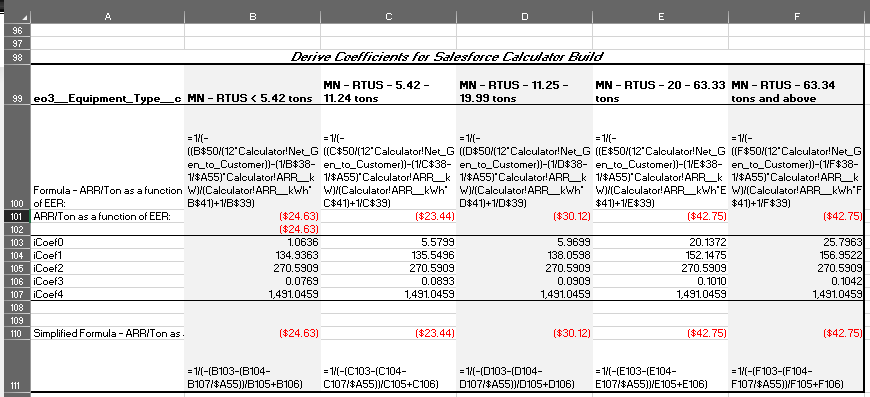

In [116]:
file_calculator = 'data/Flexible Qualifying Calculator.xlsx'
df_boundary = pd.read_excel(file_calculator, sheet_name='Calculator')
# df_boundary.info()

In [117]:
df_boundary = xu.locate_table_by_header(df_boundary, header='Derive Coefficients for Salesforce Calculator Build', 
                                        rows_after_header=15)
df_boundary.head(10)

Objective  \
0  Derive Coefficients for Salesforce Calculator ...   
1                             eo3__Equipment_Type__c   
2            Formula - ARR/Ton as a function of EER:   
3                      ARR/Ton as a function of EER:   
4                                                NaN   
5                                             iCoef0   
6                                             iCoef1   
7                                             iCoef2   
8                                             iCoef3   
9                                             iCoef4   

                                          Unnamed: 1  \
0                                                NaN   
1                              MN - RTUS < 5.42 tons   
2  =1/(-((B$50/(12*Calculator!Net_Gen_to_Customer...   
3                                         -24.634197   
4                                         -24.634197   
5                                           1.063555   
6                                         134.936284   
7                                         270.590872   
8                                           0.076923   
9                                        1491.045936   

                                          Unnamed: 2  \
0                                                NaN   
1                      MN - RTUS - 5.42 - 11.24 tons   
2  =1/(-((C$50/(12*Calculator!Net_Gen_to_Customer...   
3                                         -23.443816   
4                                                NaN   
5                                           5.579859   
6                                         135.549631   
7                                         270.590872   
8                                           0.089286   
9                                        1491.045936   

                                          Unnamed: 3  \
0                                                NaN   
1                     MN - RTUS - 11.25 - 19.99 tons   
2  =1/(-((D$50/(12*Calculator!Net_Gen_to_Customer...   
3                                          -30.12354   
4                                                NaN   
5                                           5.969913   
6                                         138.059809   
7                                         270.590872   
8                                           0.090909   
9                                        1491.045936   

                                          Unnamed: 4  \
0                                                NaN   
1                        MN - RTUS - 20 - 63.33 tons   
2  =1/(-((E$50/(12*Calculator!Net_Gen_to_Customer...   
3                                         -42.754108   
4                                                NaN   
5                                          20.137188   
6                                         152.147544   
7                                         270.590872   
8                                            0.10101   
9                                        1491.045936   

                                          Unnamed: 5 Unnamed: 6 Unnamed: 7  \
0                                                NaN        NaN        NaN   
1                   MN - RTUS - 63.34 tons and above        NaN        NaN   
2  =1/(-((F$50/(12*Calculator!Net_Gen_to_Customer...        NaN        NaN   
3                                         -42.751889        NaN        NaN   
4                                                NaN        NaN        NaN   
5                                          25.796314        NaN        NaN   
6                                         156.952204        NaN        NaN   
7                                         270.590872        NaN        NaN   
8                                           0.104167        NaN        NaN   
9                                        1491.045936        NaN        NaN   

  Unnamed: 8 Unnamed: 9  ... Unnamed: 15  Unnamed: 16  Unnamed: 17  \
0        NaN        NaN  ... 

In [118]:
columns_idx = list(df_boundary.iloc[:,0] == "eo3__Equipment_Type__c").index(True)
# Set table column names to match eo3__Equipment_Type__c names
df_boundary.columns = df_boundary.iloc[columns_idx,:].values
# df_boundary
coefficients = df_boundary['eo3__Equipment_Type__c'].str.startswith('iC').fillna(False)
df_boundary.loc[coefficients,:].dropna(axis=1)

eo3__Equipment_Type__c MN - RTUS < 5.42 tons MN - RTUS - 5.42 - 11.24 tons  \
5                 iCoef0              1.063555                      5.579859   
6                 iCoef1            134.936284                    135.549631   
7                 iCoef2            270.590872                    270.590872   
8                 iCoef3              0.076923                      0.089286   
9                 iCoef4           1491.045936                   1491.045936   

  MN - RTUS - 11.25 - 19.99 tons MN - RTUS - 20 - 63.33 tons  \
5                       5.969913                   20.137188   
6                     138.059809                  152.147544   
7                     270.590872                  270.590872   
8                       0.090909                     0.10101   
9                    1491.045936                 1491.045936   

  MN - RTUS - 63.34 tons and above  
5                        25.796314  
6                       156.952204  
7                       270.590872  
8                         0.104167  
9                      1491.045936

#### Create "qualified_SEER" as a function of EER formula

In [119]:
# NEW 7-07-21
def qualified_SEER(df_boundary, eo3__Equipment_Type__c, EER):
    coefficients = df_boundary['eo3__Equipment_Type__c'].str.startswith('iCoef').fillna(False)
    df = df_boundary.loc[coefficients,:].dropna(axis=1)
    iCoef0, iCoef1, iCoef2, iCoef3, iCoef4 = df_boundary.loc[coefficients,eo3__Equipment_Type__c].values
    SEER = 1/(-(iCoef0-(iCoef1-iCoef4/EER))/iCoef2+iCoef3)
#     display(iCoef0,iCoef1,iCoef2, iCoef3, iCoef4)
    return round(SEER,1)

Test the qualified_SEER formula

In [120]:
display(labels[3])
qualified_SEER(df_boundary,labels[3], 10.9)

'MN - RTUS - 20 - 63.33 tons'

12.0

In [121]:
# SEER_test = pd.DataFrame(data={'EER': np.arange(9,14,0.1)})
# SEER_test['SEER'] = SEER_test['EER'].apply(lambda x: qualified_SEER(df_boundary,dx_unit,x))
# SEER_test
# SEER_test.plot(x='EER', y='SEER')
# # plt.xlim(9.5,10)
# plt.show()

### Boundary Curve Example

In [122]:
qualified_SEER(df_boundary,dx_unit,10)

26.4

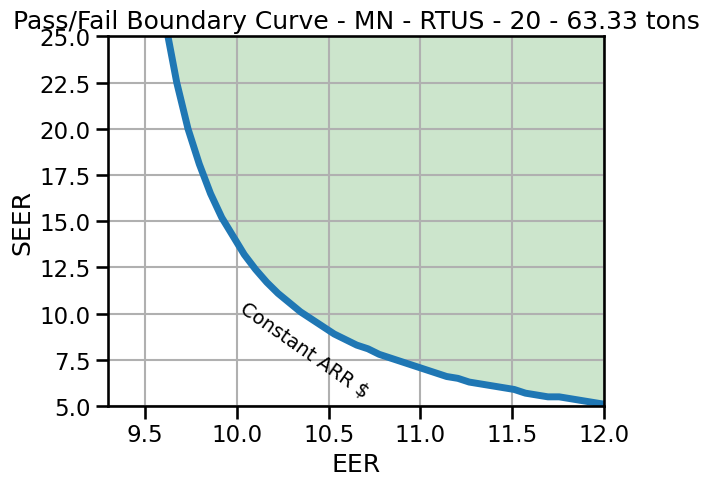

In [123]:
dx_unit = labels[3]
SEERs = [qualified_SEER(df_boundary,dx_unit,eer) for eer in np.linspace(9,14)]
plt.plot(np.linspace(9,12),SEERs, linewidth=5)
plt.ylim(5,25)
plt.ylabel('SEER')
plt.xlabel('EER')
plt.title(f'Pass/Fail Boundary Curve - {labels[3]}')
plt.fill_between(np.linspace(9,12),SEERs,y2=50, alpha=0.2, color='green', label='Qualified')
plt.grid(axis='both')
plt.annotate('Constant ARR $',xy=(10,5.5),xycoords='data',xytext=(10,5.5), rotation=-35, fontsize = 14)
plt.xlim(9.3,12)

# Min_SEER = df.loc[df['dx_units_category']==dx_unit,'Min_SEER__c'].unique()[0]
# Min_EER = df.loc[df['dx_units_category']==dx_unit,'Min_EER__c'].unique()[0]
# plt.annotate('Minimum Qualifed ARR', xy=(Min_EER, Min_SEER),  xycoords='data',
#         xytext=(Min_EER*1.12, Min_SEER*0.85), textcoords='data',
#         arrowprops=dict(facecolor='black', shrink=0.05),
#         horizontalalignment='right', verticalalignment='top')
plt.show()

### Current 'static' minimum ARR/Ton values by Equipment Type

In [126]:
df_min_arr_ton = pd.read_excel(file_calculator, sheet_name='Calculator')
# df_min_arr_ton.info()

In [127]:
df_min_arr_ton = xu.locate_table_by_header(df_min_arr_ton, header="Minimum Qualifying ARR Values using 2021 'static' Rules", 
                                        rows_after_header=25)
# df_min_arr_ton.head(20)

In [128]:
columns_idx = list(df_min_arr_ton.iloc[:,0] == "eo3__Equipment_Type__c").index(True)
# Set table column names to match eo3__Equipment_Type__c names
df_min_arr_ton.columns = df_min_arr_ton.iloc[columns_idx,:].values
# df_min_arr_ton
coefficients = df_min_arr_ton['eo3__Equipment_Type__c'].str.startswith('Minimum Qualified ARR').fillna(False)
df_min_arr_ton = df_min_arr_ton.loc[coefficients,labels].dropna(axis=1)
df_min_arr_ton

MN - RTUS < 5.42 tons MN - RTUS - 5.42 - 11.24 tons  \
17             13.006583                     68.238041   

   MN - RTUS - 11.25 - 19.99 tons MN - RTUS - 20 - 63.33 tons  \
17                       73.00815                  246.264688   

   MN - RTUS - 63.34 tons and above  
17                       315.472107

### What combinations of EER and SEER result in an ARR_per_ton that exceeds the Weighted_Minimum_ARR_per_ton for each Equipment Type?

The Goal is to produce a table with EER vs SEER and a pass/fail status for each combination

In [129]:
df['Equipment SEER/IEER'].min()

8.4

In [130]:
# min_SEER = df_equipment_equipment_specs['SEER_Baseline__c'].min()
min_SEER = df['Equipment SEER/IEER'].min()
max_SEER = df['Equipment SEER/IEER'].max()
# min_EER = df_equipment_equipment_specs['EER_Baseline__c'].min()
min_EER = df['Equipment EER'].min()
# max_EER = df_equipment_equipment_specs['EER_Baseline__c'].max()
max_EER = df['Equipment EER'].max()
max_SEER

23.2

In [131]:
increment_size = 0.1
EER_index = np.arange(min_EER,max_EER+increment_size,increment_size)
# SEER_index = np.arange(min_SEER,max_SEER+increment_size,increment_size)
df_EER_SEER = pd.DataFrame(index=np.round(EER_index,1), columns=labels, data=0).rename_axis('EER').rename_axis(columns='eo3__Equipment_Type__c')
df_EER_SEER.head(4)

eo3__Equipment_Type__c  MN - RTUS < 5.42 tons  MN - RTUS - 5.42 - 11.24 tons  \
EER                                                                            
8.7                                         0                              0   
8.8                                         0                              0   
8.9                                         0                              0   
9.0                                         0                              0   

eo3__Equipment_Type__c  MN - RTUS - 11.25 - 19.99 tons  \
EER                                                      
8.7                                                  0   
8.8                                                  0   
8.9                                                  0   
9.0                                                  0   

eo3__Equipment_Type__c  MN - RTUS - 20 - 63.33 tons  \
EER                                                   
8.7                                               0   
8.8                                               0   
8.9                                               0   
9.0                                               0   

eo3__Equipment_Type__c  MN - RTUS - 63.34 tons and above  
EER                                                       
8.7                                                    0  
8.8                                                    0  
8.9                                                    0  
9.0                                                    0

### Calculate minimum qualifying SEER value table

In [132]:
for col in df_EER_SEER.columns:
    seers = np.array([qualified_SEER(df_boundary,col,eer) for eer in df_EER_SEER.index.values])
    EER_Baseline__c = df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == col,'EER_Baseline__c'].values[0]
    SEER_Baseline__c = df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == col,'SEER_Baseline__c'].values[0]
    #     Is the EER value higher than EER Baseline?
    qualified_seers = np.where((df_EER_SEER.index.values>EER_Baseline__c),seers,99.9)
    #     Is the SEER value higher than SEER Baseline?
    qualified_seers = np.where((qualified_seers>SEER_Baseline__c),qualified_seers,SEER_Baseline__c)
    qualified_seers = np.where(qualified_seers!=99.9,qualified_seers,'Not Qualified')
    df_EER_SEER[col] = qualified_seers

# df_EER_SEER.sample(5).sort_index()

In [133]:
df_EER_SEER.loc[9.5:12]

eo3__Equipment_Type__c MN - RTUS < 5.42 tons MN - RTUS - 5.42 - 11.24 tons  \
EER                                                                          
9.5                            Not Qualified                 Not Qualified   
9.6                            Not Qualified                 Not Qualified   
9.7                            Not Qualified                 Not Qualified   
9.8                            Not Qualified                 Not Qualified   
9.9                            Not Qualified                 Not Qualified   
10.0                           Not Qualified                 Not Qualified   
10.1                           Not Qualified                 Not Qualified   
10.2                           Not Qualified                 Not Qualified   
10.3                           Not Qualified                 Not Qualified   
10.4                           Not Qualified                 Not Qualified   
10.5                           Not Qualified                 Not Qualified   
10.6                           Not Qualified                 Not Qualified   
10.7                           Not Qualified                 Not Qualified   
10.8                           Not Qualified                 Not Qualified   
10.9                           Not Qualified                 Not Qualified   
11.0                           Not Qualified                 Not Qualified   
11.1                                    13.3                          13.7   
11.2                                    13.0                          12.9   
11.3                                    13.0                          12.2   
11.4                                    13.0                          11.6   
11.5                                    13.0                          11.2   
11.6                                    13.0                          11.2   
11.7                                    13.0                          11.2   
11.8                                    13.0                          11.2   
11.9                                    13.0                          11.2   
12.0                                    13.0                          11.2   

eo3__Equipment_Type__c MN - RTUS - 11.25 - 19.99 tons  \
EER                                                     
9.5                                     Not Qualified   
9.6                                     Not Qualified   
9.7                                     Not Qualified   
9.8                                     Not Qualified   
9.9                                     Not Qualified   
10.0                                    Not Qualified   
10.1                                    Not Qualified   
10.2                                    Not Qualified   
10.3                                    Not Qualified   
10.4                                    Not Qualified   
10.5                                    Not Qualified   
10.6                                    Not Qualified   
10.7                                    Not Qualified   
10.8                                    Not Qualified   
10.9                                             13.6   
11.0                                             12.8   
11.1                                             12.1   
11.2                                             11.5   
11.3                                             11.0   
11.4                                             11.0   
11.5                                             11.0   
11.6                                             11.0   
11.7                                             11.0   
11.8                                             11.0   
11.9                                             11.0   
12.0                                             11.0   

eo3__Equipment_Type__c MN - RTUS - 20 - 63.33 tons  \
EER                                                  
9.5                                  Not Qualified   
9.6                                  Not Qualified   
9.

### Comparison of Static vs Flexible Minimum Qualifying

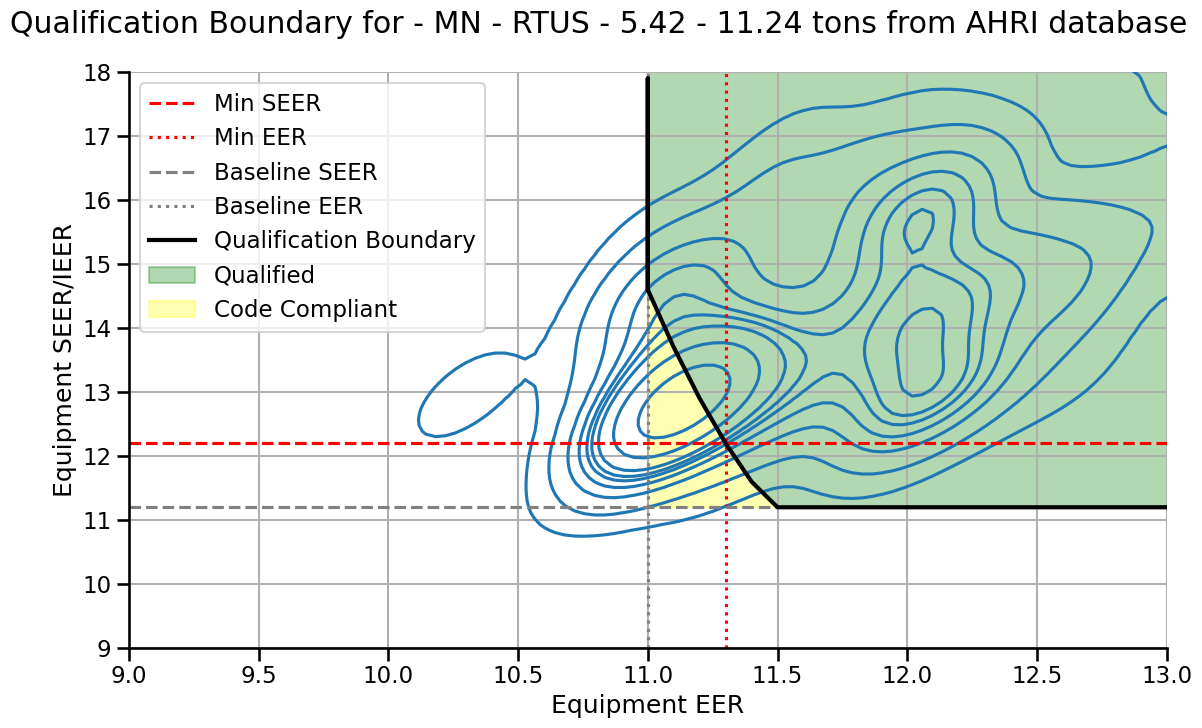

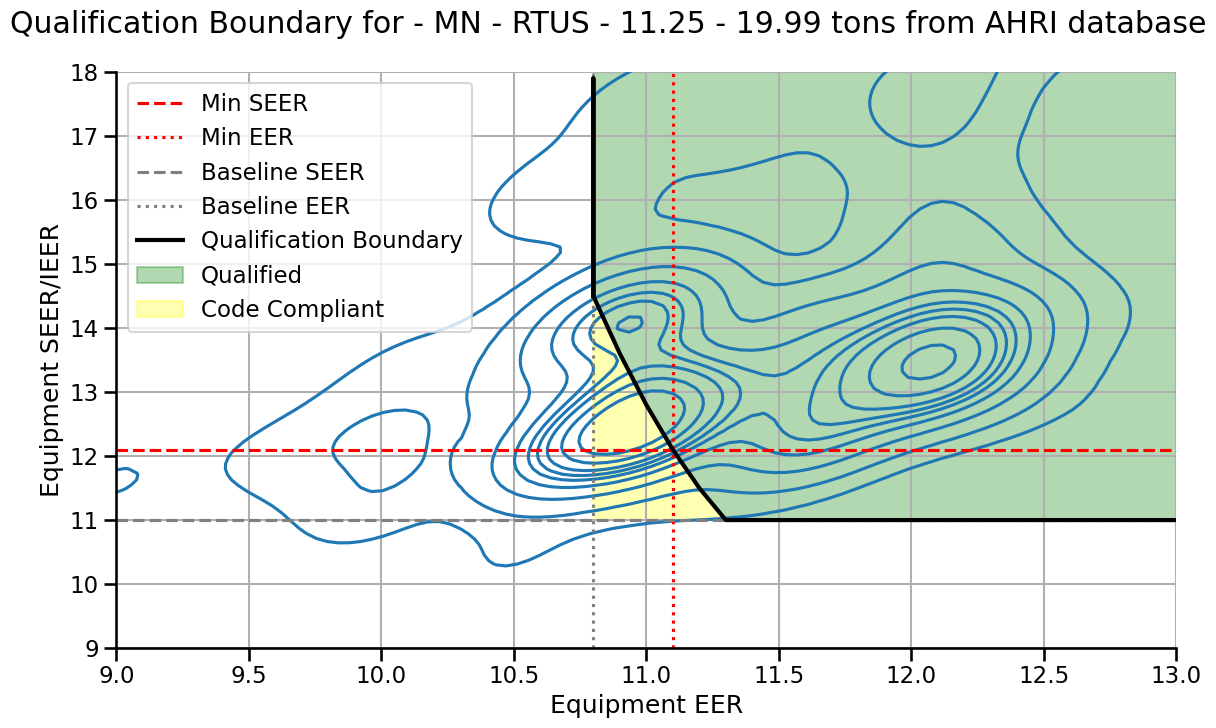

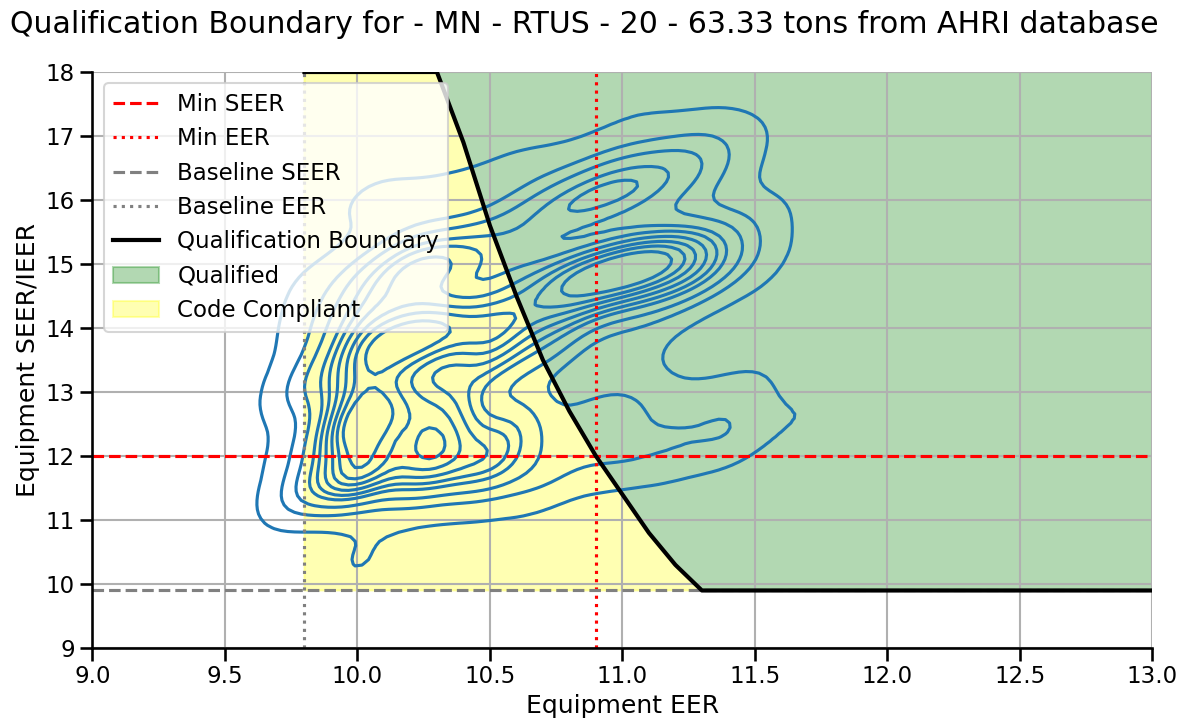

In [134]:
# sns.set_context('talk')
# for dx_unit in ['MN - RTUS - 5.42 - 11.24 tons','MN - RTUS - 11.25 - 19.99 tons', 'MN - RTUS - 20 - 63.33 tons'][:1]:
# for dx_unit in labels[1:2]:
for dx_unit in labels[1:-1]:
    SEER_max_display = 18
    SEER_baseline = float(df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == dx_unit, 'SEER_Baseline__c'] )
    EER_baseline = float(df_equipment.loc[df_equipment['eo3__Equipment_Type__c'] == dx_unit, 'EER_Baseline__c'])
    Min_SEER = df.loc[df['dx_units_category']==dx_unit,'Min_SEER__c'].unique()[0]
    Min_EER = df.loc[df['dx_units_category']==dx_unit,'Min_EER__c'].unique()[0]
    sns.displot(data = df.loc[df['dx_units_category'] == dx_unit], x='Equipment EER',
                y='Equipment SEER/IEER', kind='kde', height=7, aspect=1.7)
#     plot min qualifying lines
    plt.hlines(Min_SEER,9,13, linestyle='--', colors='red', label='Min SEER')
    plt.vlines(Min_EER,9,SEER_max_display, linestyle='dotted', colors='red', label='Min EER')
#     plot baseline EER/SEER lines
    plt.hlines(SEER_baseline,9,13, linestyle='--', colors='gray', label='Baseline SEER')
    plt.vlines(EER_baseline,9,SEER_max_display, linestyle='dotted', colors='gray', label='Baseline EER')
#     calculate min qualifying boundary curve coordinates
    eers = list(np.arange(EER_baseline,SEER_max_display,0.1))
    seers = list(np.clip([qualified_SEER(df_boundary,dx_unit,eer) for eer in eers],SEER_baseline,SEER_max_display))
    seers_vline = list(np.arange(qualified_SEER(df_boundary,dx_unit,EER_baseline),SEER_max_display,0.1))
    eers_vline = [EER_baseline]*len(seers_vline)
    eers = eers_vline + eers
    seers = seers_vline + seers
    
#     plot flexible min qualifying boundary curve
    plt.plot(eers,seers, color='black', linewidth=3, label='Qualification Boundary')
# Fill right and above curved boundary with green
    plt.fill_between(eers,seers,y2=SEER_max_display, alpha=0.3, color='green', label='Qualified')
# Fill left of curved boundary with yellow
    plt.fill_betweenx(seers,eers,[EER_baseline]*len(seers), alpha=0.3, color='yellow', label='Code Compliant')
#     titles, grids, and plot limits
    plt.suptitle(f'Qualification Boundary for - {dx_unit} from AHRI database', y=1.05)
    plt.xlim(9,13)
    plt.ylim(9,SEER_max_display)
    plt.grid(axis='both')
    plt.legend(loc='upper left')
    plt.margins(0.9)
    plt.show()

### Determine flexible criteria qualification status for all AHRI units

In [135]:
equipment_ = df['dx_units_category']
EER_ = df['Equipment EER'].round(1)
SEER_ = df['Equipment SEER/IEER'].round(1)
qualified = []
flex_qualified_SEER = []

for equipment, EER, SEER in zip(equipment_, EER_, SEER_):
#     print(EER, equipment)
    if df_EER_SEER.loc[EER,equipment] == "Not Qualified":
        qualified.append(False)
        flex_qualified_SEER.append("EER too low")
        continue
    min_SEER = round(float(df_EER_SEER.loc[EER,equipment]),1)
    if SEER > min_SEER:
        qualified_ = True
    else:
        qualified_ = False
    flex_qualified_SEER.append(min_SEER)
    qualified.append(qualified_)

In [136]:
# sum(qualified), len(qualified), len(equipment_),  len(flex_qualified_SEER)

In [137]:
df['qualified_SEER_(flex_criteria)'] = flex_qualified_SEER
df['qualified_(flex_criteria)'] = qualified

In [138]:
df[['dx_units_category','Equipment EER', 'Equipment SEER/IEER',
       'qualified_EER', 'qualified_SEER', 'qualified_(standard_criteria)','qualified_SEER_(flex_criteria)', 'qualified_(flex_criteria)' ]]

dx_units_category  Equipment EER  Equipment SEER/IEER  \
0      MN - RTUS - 11.25 - 19.99 tons          11.10                 14.6   
1      MN - RTUS - 11.25 - 19.99 tons          10.18                 12.0   
2      MN - RTUS - 11.25 - 19.99 tons           8.99                 11.6   
3      MN - RTUS - 11.25 - 19.99 tons           8.99                 11.6   
4      MN - RTUS - 11.25 - 19.99 tons          10.00                 11.6   
...                               ...            ...                  ...   
14041           MN - RTUS < 5.42 tons           9.96                  9.6   
14042           MN - RTUS < 5.42 tons          11.20                 13.5   
14043           MN - RTUS < 5.42 tons          11.20                 13.5   
14044           MN - RTUS < 5.42 tons          11.50                 14.3   
14045           MN - RTUS < 5.42 tons          11.70                 14.3   

       qualified_EER  qualified_SEER  qualified_(standard_criteria)  \
0               True            True                           True   
1              False           False                          False   
2              False           False                          False   
3              False           False                          False   
4              False           False                          False   
...              ...             ...                            ...   
14041          False           False                          False   
14042           True           False                          False   
14043           True           False                          False   
14044           True            True                           True   
14045           True            True                           True   

      qualified_SEER_(flex_criteria)  qualified_(flex_criteria)  
0                               12.1                       True  
1                        EER too low                      False  
2                        EER too low                      False  
3                        EER too low                      False  
4                        EER too low                      False  
...                              ...                        ...  
14041                    EER too low                      False  
14042                           13.0                       True  
14043                           13.0                       True  
14044                           13.0                       True  
14045                           13.0                       True  

[14046 rows x 8 columns]

In [139]:
(df['qualified_(flex_criteria)'] > df['qualified_(standard_criteria)']).sum()

1551

## Comparison of qualifying criteria's impact on qualified AHRI units

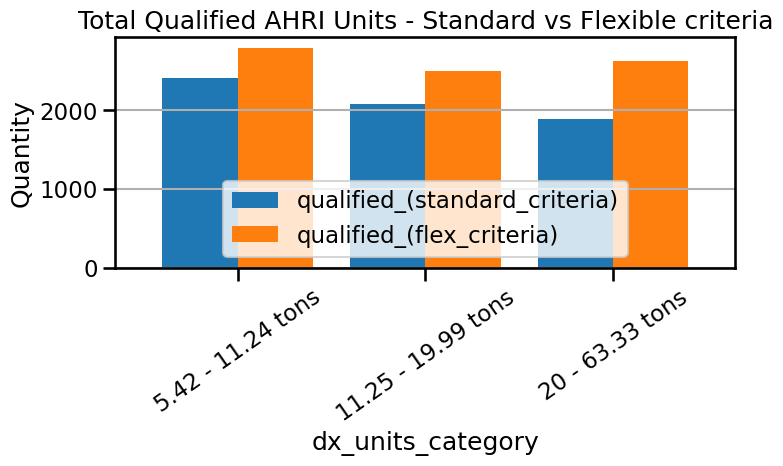

In [152]:
df_qualification_compare = df.groupby('dx_units_category').sum()\
    [['qualified_(standard_criteria)','qualified_(flex_criteria)']]
df_qualification_compare.loc[labels[1:-1],:].plot(kind='bar', width=0.8, figsize=(8,3))
plt.legend(loc='lower center')
plt.ylabel('Quantity')
plt.xticks(labels=[x.split("RTUS - ")[-1] for x in labels[1:-1]], ticks=[0,1,2], rotation=35)
plt.title("Total Qualified AHRI Units - Standard vs Flexible criteria")
plt.grid(axis='y')

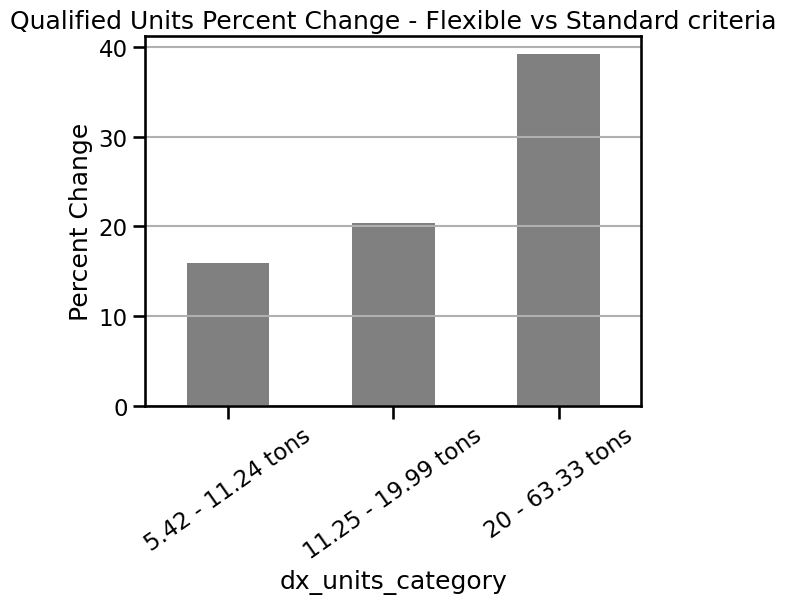

In [141]:
(df_qualification_compare.T.pct_change().round(3)*100).loc["qualified_(flex_criteria)",labels[1:-1]].plot(kind='bar', color='grey')
plt.ylabel("Percent Change")
plt.grid(axis='y')
plt.xticks(labels=[x.split("RTUS - ")[-1] for x in labels[1:-1]], ticks=[0,1,2], rotation=35)
plt.title("Qualified Units Percent Change - Flexible vs Standard criteria")
plt.show()

In [142]:
pd.options.display.max_rows = 200

## Projected Participation

In [143]:
df_history_summary = df_history.groupby('F_Equipment_Name_Proposed__c').agg({'Name':'count',
                                                        'I_Qty_Prop_Equip__c':sum,
                                                       'i_unit_cooling_tons_mc__c':'mean',
                                                        'I_EER_MC04__c':'mean',
                                                        'i_SEER_MC04__c':'mean',
                                                         'P_Cooling_Hrs_mc4__c':'mean'
                                                       }).loc[labels]
df_history_summary.rename(columns={'Name':'Participants'}, inplace=True)
df_history_summary

Participants  I_Qty_Prop_Equip__c  \
F_Equipment_Name_Proposed__c                                          
MN - RTUS < 5.42 tons                     2240               3496.0   
MN - RTUS - 5.42 - 11.24 tons             1114               1695.0   
MN - RTUS - 11.25 - 19.99 tons             529                818.0   
MN - RTUS - 20 - 63.33 tons                195                320.0   
MN - RTUS - 63.34 tons and above            21                 29.0   

                                  i_unit_cooling_tons_mc__c  I_EER_MC04__c  \
F_Equipment_Name_Proposed__c                                                 
MN - RTUS < 5.42 tons                              3.787759      12.304392   
MN - RTUS - 5.42 - 11.24 tons                      7.981293      12.172792   
MN - RTUS - 11.25 - 19.99 tons                    14.553025      12.100681   
MN - RTUS - 20 - 63.33 tons                       29.595949      11.595436   
MN - RTUS - 63.34 tons and above                  86.544286      11.080952   

                                  i_SEER_MC04__c  P_Cooling_Hrs_mc4__c  
F_Equipment_Name_Proposed__c                                            
MN - RTUS < 5.42 tons                  15.089196            600.486161  
MN - RTUS - 5.42 - 11.24 tons          14.265934            621.456014  
MN - RTUS - 11.25 - 19.99 tons         14.483043            786.449905  
MN - RTUS - 20 - 63.33 tons            13.920656            820.092308  
MN - RTUS - 63.34 tons and above       15.107143           1089.857143

In [144]:
df_history_summary['Percent_projected_change_quantity'] = (df_qualification_compare.T.pct_change()*100).round(3).loc['qualified_(flex_criteria)'].replace(100,np.nan)

In [145]:
df_history_summary.round(2)

Participants  I_Qty_Prop_Equip__c  \
F_Equipment_Name_Proposed__c                                          
MN - RTUS < 5.42 tons                     2240               3496.0   
MN - RTUS - 5.42 - 11.24 tons             1114               1695.0   
MN - RTUS - 11.25 - 19.99 tons             529                818.0   
MN - RTUS - 20 - 63.33 tons                195                320.0   
MN - RTUS - 63.34 tons and above            21                 29.0   

                                  i_unit_cooling_tons_mc__c  I_EER_MC04__c  \
F_Equipment_Name_Proposed__c                                                 
MN - RTUS < 5.42 tons                                  3.79          12.30   
MN - RTUS - 5.42 - 11.24 tons                          7.98          12.17   
MN - RTUS - 11.25 - 19.99 tons                        14.55          12.10   
MN - RTUS - 20 - 63.33 tons                           29.60          11.60   
MN - RTUS - 63.34 tons and above                      86.54          11.08   

                                  i_SEER_MC04__c  P_Cooling_Hrs_mc4__c  \
F_Equipment_Name_Proposed__c                                             
MN - RTUS < 5.42 tons                      15.09                600.49   
MN - RTUS - 5.42 - 11.24 tons              14.27                621.46   
MN - RTUS - 11.25 - 19.99 tons             14.48                786.45   
MN - RTUS - 20 - 63.33 tons                13.92                820.09   
MN - RTUS - 63.34 tons and above           15.11               1089.86   

                                  Percent_projected_change_quantity  
F_Equipment_Name_Proposed__c                                         
MN - RTUS < 5.42 tons                                           NaN  
MN - RTUS - 5.42 - 11.24 tons                                 15.86  
MN - RTUS - 11.25 - 19.99 tons                                20.36  
MN - RTUS - 20 - 63.33 tons                                   39.20  
MN - RTUS - 63.34 tons and above                                NaN

Save output to disk

In [146]:
df_history_summary.round(2).to_csv('DX_Unit History Summary 2017-20.csv')

### Projected change by Equipment type for count, size, and average EER and SEER

#### Per Standard Criteria

In [147]:
df_AHRI_passing_standard = df.loc[df['qualified_(standard_criteria)']].groupby('eo3__Equipment_Type__c').agg({'eo3__Equipment_Type__c':'count',
                                                       'Unit Size (Tons)':'mean',
                                                        'Equipment EER':'mean',
                                                        'Equipment SEER/IEER':'mean'
                                                       }).loc[labels[1:-1]].round(2)
df_AHRI_passing_standard.rename(columns={'eo3__Equipment_Type__c':'I_Qty_Prop_Equip__c'}, inplace=True)
df_AHRI_passing_standard

I_Qty_Prop_Equip__c  Unit Size (Tons)  \
eo3__Equipment_Type__c                                                  
MN - RTUS - 5.42 - 11.24 tons                  2408              7.91   
MN - RTUS - 11.25 - 19.99 tons                 2078             15.66   
MN - RTUS - 20 - 63.33 tons                    1885             30.89   

                                Equipment EER  Equipment SEER/IEER  
eo3__Equipment_Type__c                                              
MN - RTUS - 5.42 - 11.24 tons           12.15                15.34  
MN - RTUS - 11.25 - 19.99 tons          11.92                14.24  
MN - RTUS - 20 - 63.33 tons             11.15                14.88

#### Per Flexible Criteria

In [148]:
df_AHRI_passing_flex = df.loc[df['qualified_(flex_criteria)']].groupby('eo3__Equipment_Type__c').agg({'eo3__Equipment_Type__c':'count',
                                                       'Unit Size (Tons)':'mean',
                                                        'Equipment EER':'mean',
                                                        'Equipment SEER/IEER':'mean'
                                                       }).loc[labels[1:-1]].round(2)
df_AHRI_passing_flex.rename(columns={'eo3__Equipment_Type__c':'I_Qty_Prop_Equip__c'}, inplace=True)
df_AHRI_passing_flex

I_Qty_Prop_Equip__c  Unit Size (Tons)  \
eo3__Equipment_Type__c                                                  
MN - RTUS - 5.42 - 11.24 tons                  2790              7.92   
MN - RTUS - 11.25 - 19.99 tons                 2501             15.73   
MN - RTUS - 20 - 63.33 tons                    2624             31.98   

                                Equipment EER  Equipment SEER/IEER  
eo3__Equipment_Type__c                                              
MN - RTUS - 5.42 - 11.24 tons           12.02                15.15  
MN - RTUS - 11.25 - 19.99 tons          11.76                14.17  
MN - RTUS - 20 - 63.33 tons             11.03                14.92

In [149]:
df_std_to_flex_pct_change = df_AHRI_passing_flex.div(df_AHRI_passing_standard)
df_std_to_flex_pct_change.round(2)

I_Qty_Prop_Equip__c  Unit Size (Tons)  \
eo3__Equipment_Type__c                                                  
MN - RTUS - 5.42 - 11.24 tons                  1.16              1.00   
MN - RTUS - 11.25 - 19.99 tons                 1.20              1.00   
MN - RTUS - 20 - 63.33 tons                    1.39              1.04   

                                Equipment EER  Equipment SEER/IEER  
eo3__Equipment_Type__c                                              
MN - RTUS - 5.42 - 11.24 tons            0.99                 0.99  
MN - RTUS - 11.25 - 19.99 tons           0.99                 1.00  
MN - RTUS - 20 - 63.33 tons              0.99                 1.00

Save output to disk

In [150]:
# df_AHRI_passing_standard.to_csv('DX_AHRI_passing_standard.csv')
# df_AHRI_passing_flex.to_csv('DX_AHRI_passing_flex.csv')
# df_std_to_flex_pct_change.to_csv('DX_Unit Standard to Flex pct change.csv')

## Implementation - Technical Assumptions & Salesforce

#### Technical Assumptions table
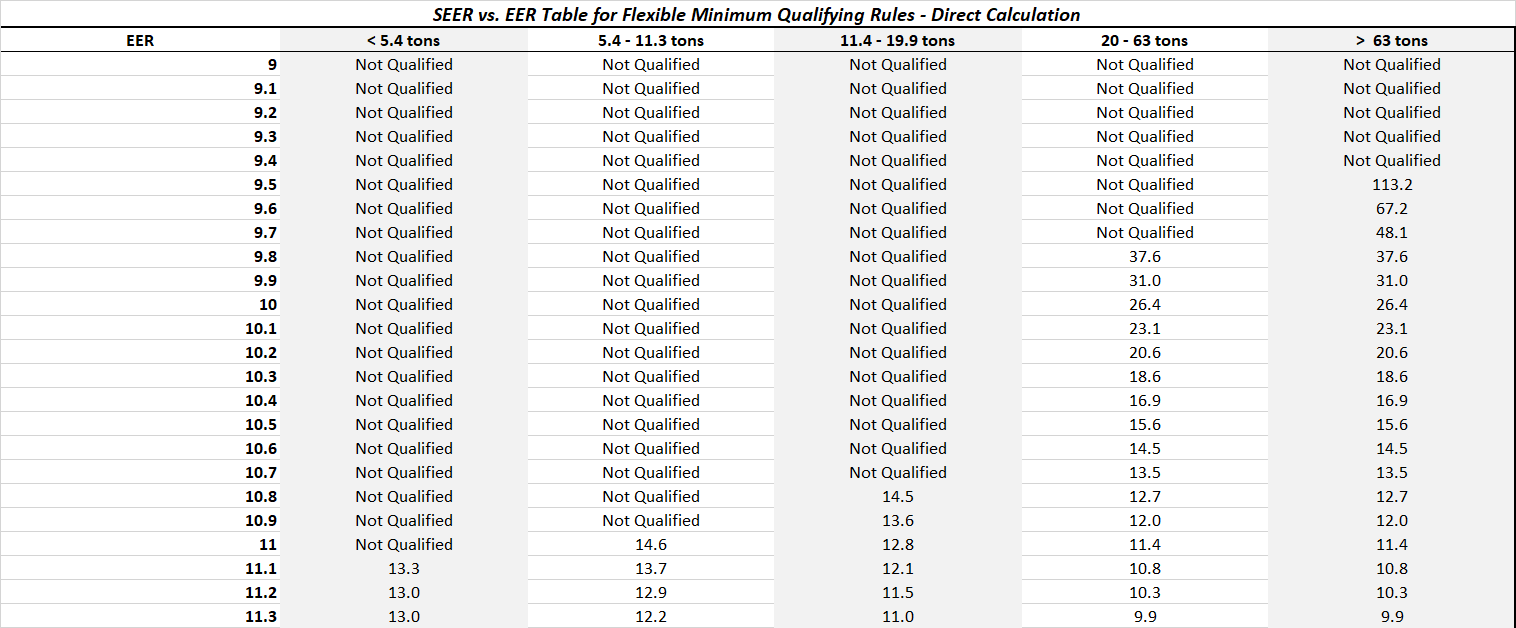

#### Salesforce Implementation
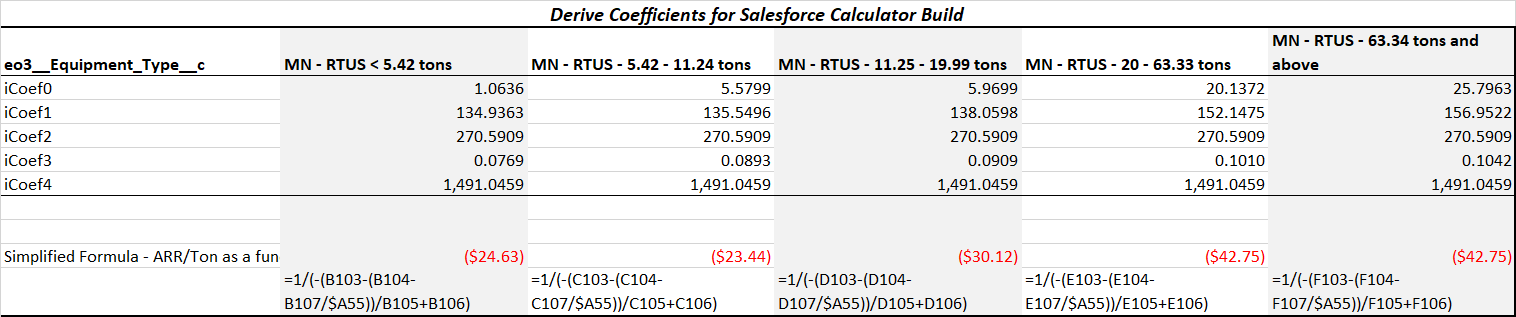

# END